In [1]:
# import ambulance_game as abg
import random
import math
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ambulance_game.simulation import (
    simulate_model,
    get_average_simulated_state_probabilities,
)

from ambulance_game.markov import (
    visualise_markov_chain,
    is_accepting_state,
    build_states,
    get_transition_matrix,
    get_steady_state_algebraically,
    get_markov_state_probabilities,
)

# Simulation

In [3]:
def extract_total_individuals_and_the_ones_within_target_for_both_classes(individuals, target):
    class_2_inds, class_2_inds_within_target = 0, 0
    class_1_inds, class_1_inds_within_target = 0, 0
    for individual in individuals:
        ind_class = len(individual.data_records) - 1
        rec = individual.data_records[-1]
        if rec.node == 2 and ind_class == 0:
            class_1_inds += 1
            if rec.waiting_time + rec.service_time < target:
                class_1_inds_within_target += 1
        elif rec.node == 2 and ind_class == 1:
            class_2_inds += 1
            if rec.waiting_time + rec.service_time < target:
                class_2_inds_within_target += 1

    return class_2_inds, class_2_inds_within_target, class_1_inds, class_1_inds_within_target

In [4]:
def get_mean_proportion_of_individuals_within_target_for_multiple_runs(
    lambda_2,
    lambda_1,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    buffer_capacity,
    seed_num,
    num_of_trials,
    runtime,
    target,
):
    class_2_proportions = []
    class_1_proportions = []
    combined_proportions = []

    if seed_num == None:
        seed_num = random.random()

    for trial in range(num_of_trials):
        individuals = simulate_model(
            lambda_2=lambda_2, 
            lambda_1=lambda_1, 
            mu=mu,
            num_of_servers=num_of_servers, 
            threshold=threshold,
            system_capacity=system_capacity,
            buffer_capacity=buffer_capacity,
            seed_num=seed_num + trial, 
            runtime=runtime
        ).get_all_individuals()
        (
            class_2_inds,
            class_2_inds_within_target,
            class_1_inds,
            class_1_inds_within_target,
        ) = extract_total_individuals_and_the_ones_within_target_for_both_classes(individuals, target)

        class_2_proportions.append(
            (class_2_inds_within_target / class_2_inds) if class_2_inds != 0 else 1
        )
        class_1_proportions.append(
            (class_1_inds_within_target / class_1_inds) if class_1_inds != 0 else 1
        )
        combined_proportions.append(
            (class_2_inds_within_target + class_1_inds_within_target)
            / (class_2_inds + class_1_inds)
            if (class_2_inds + class_1_inds) != 0
            else 1
        )

    return combined_proportions, class_1_proportions, class_2_proportions

# Markov Chains

## Utils function

In [5]:
def get_probability_of_accepting(
    all_states,
    pi,
    threshold, 
    system_capacity, 
    buffer_capacity,
):
    prob_accept = [
        np.sum(
            [
                pi[state]
                for state in all_states
                if is_accepting_state(
                    state=state,
                    class_type=class_type,
                    threshold=threshold,
                    system_capacity=system_capacity,
                    buffer_capacity=buffer_capacity,
                )
            ]
        )
        for class_type in range(2)
    ]
    return prob_accept


def get_proportion_of_individuals_not_lost(
    all_states,
    pi,
    lambda_1,
    lambda_2,
    threshold,
    system_capacity,
    buffer_capacity,
):
    prob_accept = get_probability_of_accepting(
        all_states,
        pi,
        threshold,
        system_capacity,
        buffer_capacity,
    )
    class_rates = [
        prob_accept[class_type]
        / ((lambda_2 * prob_accept[1]) + (lambda_1 * prob_accept[0]))
        for class_type in range(2)
    ]
    class_rates[0] *= lambda_1
    class_rates[1] *= lambda_2

    return class_rates

In [6]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
threshold = 5
system_capacity = 20
buffer_capacity = 10

target = 4

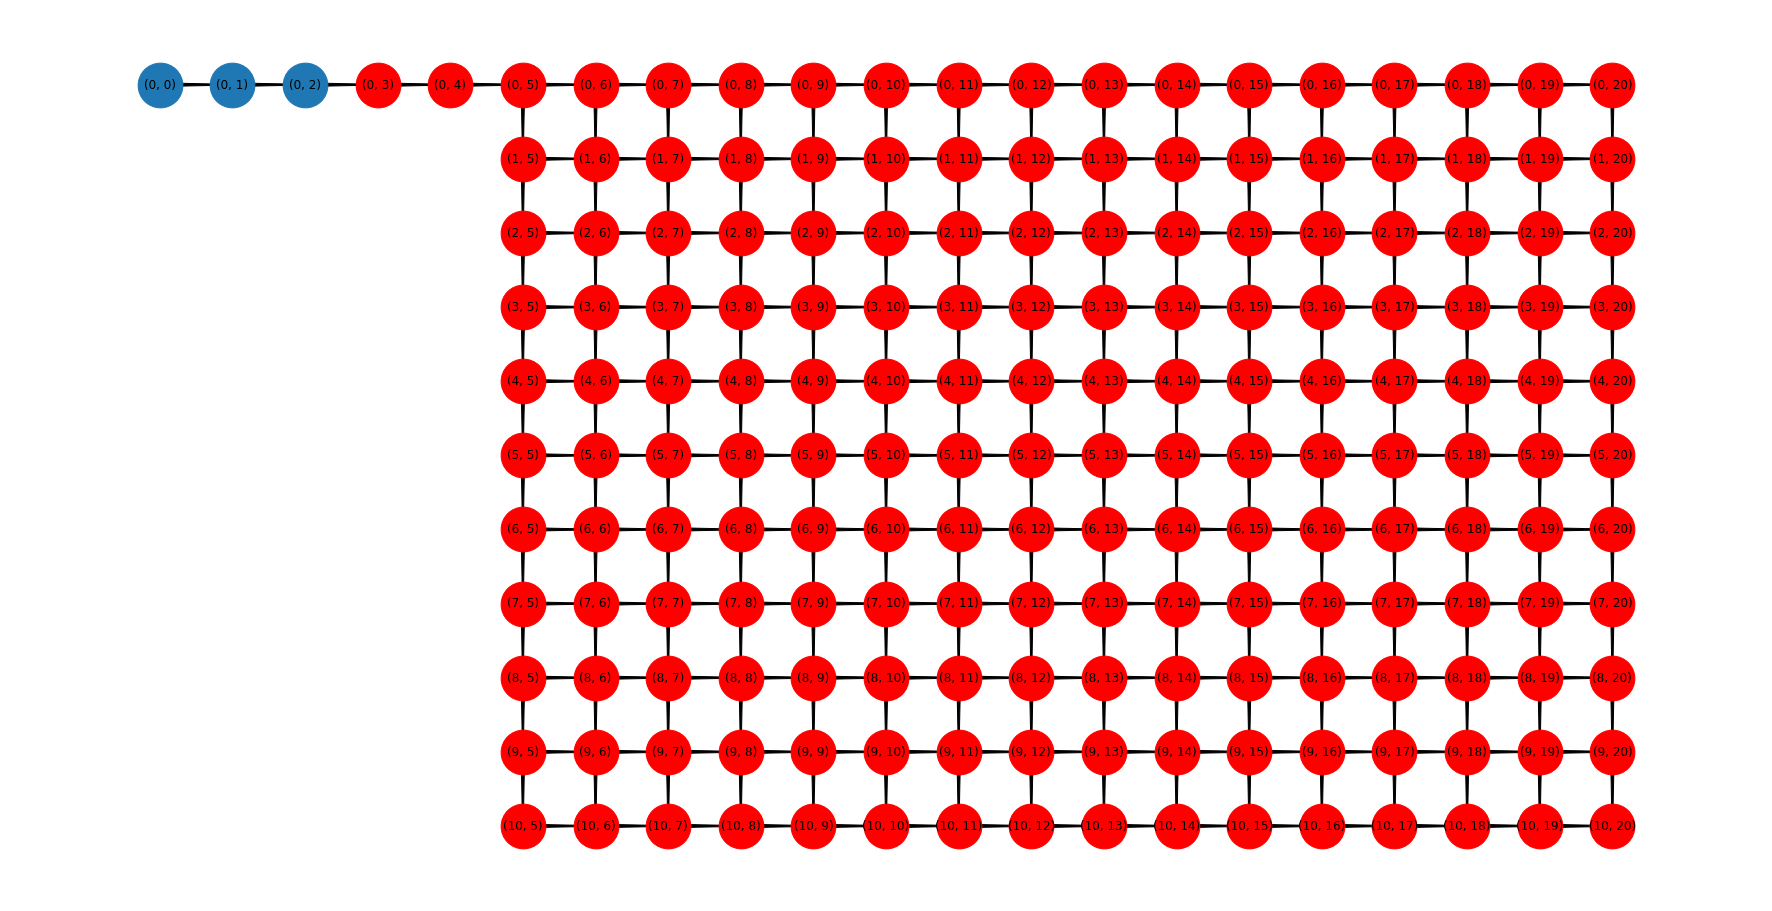

In [7]:
visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

## Theory:

- **Sum of exponentially distributed random varables (with the same parameter $\lambda$) results in Erlang distributed R.V.** 

    $$
        X_i \sim Exp(\lambda) \qquad \Rightarrow \qquad S = X_1 + X_2 + \dots + X_k \sim Erlang(k, \lambda)
    $$

- **Sum of erlang distributed random varables (with different parameters $\lambda$) results in Hypoexponentially distributied R.V.**

    $$
        S_i \sim Erlang(k_i, \lambda_i) \qquad \Rightarrow \qquad H = S_1 + S_2 + \dots + S_n \sim Hypo((k_1, \dots, k_n), (\lambda_1, \dots, \lambda_n)) \\
    $$


**Applied to Markov chain**

$S_7 = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} + X_{0,2}$

$X_{0,2}$ has a different exponential parameter than the other ones and cannot be combined to form Erlang distribution

By just considering the waiting time (excluding service time):

$S_{0,7} = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} \sim Erlang(n, \lambda)$

$P(S_{0,7} < 4) = 1 - \sum_{i=0}^{n-1} \frac{e^{-4\lambda} (4 \lambda)^i}{i!}$

## Function for JUST waiting time  (NOT USED)

In [8]:
# Function for just waiting time
def get_probability_of_waiting_time_in_system_less_than_target_for_state_just_wait(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        param = num_of_servers * mu
        prob = 1 - np.sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        prob = 1

    return prob

## Function for total time in system by adjusting $C\mu$ in $Erlang(n, C\mu)$ (NOT USED)

$$
C \tilde \mu = \frac{1}{\frac{1}{C \mu} + \frac{1}{n \mu}} \qquad \Rightarrow \qquad S \sim Erlang(n, \frac{1}{\frac{1}{C \mu} + \frac{1}{n \mu}})
$$

In [9]:
def get_probability_of_waiting_time_in_system_less_than_target_for_state_adj_mu(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        param = 1 / (1 / (num_of_servers * mu) + (1 / (mu * k)))
        prob = 1 - np.sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        param = mu
        prob = 1 - np.exp(- param * target)

    return prob

## Function for total time in system by adjusting $n$ in $Erlang(n, C\mu)$ (NOT USED)

$$
    \tilde n = n + C \qquad \Rightarrow \qquad S \sim Erlang(n + C, C\mu)
$$

In [10]:
def get_probability_of_waiting_time_in_system_less_than_target_for_state_adj_k(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        k = k + num_of_servers
        param = num_of_servers * mu
        prob = 1 - sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        param = mu
        prob = 1 - np.exp(- param * target)

    return prob

## Getting the distribution of $X_1 + \dots + X_n + X_s$

- **Using Erlang Distribution**: Sum of exponentially distributed random variables with the same parameter 
    $$
    X_1 , \dots \ X_n \sim Exp(C\mu) \quad \left( \Rightarrow X_1 + \dots + X_n \sim Erlang(n, C\mu) \right) \\
    X_s \sim Exp(\mu) \qquad \left( \Rightarrow X_s \sim Erlang(1, \mu) \right)
    $$
    
    - **CDF of $Erlang(n, \lambda)$:** 
        $$
        F(x) = 1 - \sum_{i=0}^{n-1} \frac{e^{-\lambda x} (\lambda x)^i}{i!}
        $$

- **Using Hypoexponential Ditribution**:
    $$
    \underbrace{
        X_1 , \dots \ X_n \sim Exp(C\mu), \qquad X_s \sim Exp(\mu)
    } \\
    X_1 + \dots + X_n + X_s \sim Hypo(C\mu, \dots, C\mu, \mu)
    $$
    
    - **CDF of $Hypo(\lambda_1, \dots, \lambda_N)$:**
    $$
    \begin{align}
        & F(x) = 1 - \left( \prod_{j=1}^a \lambda_j^{r_j} \right) \sum_{k=1}^a \sum_{l=1}^{r_k} \frac{\Psi_{k,l}(-\lambda_k)x^{r_k - l} e^{-\lambda_k x}}
        {(r_k - l)! (l - 1)!} \\ 
        & \textbf{where} \qquad \Psi_{k,l}(t) = - \frac{\partial^{l - 1}}{\partial t ^{l - 1}} \left( \prod_{j = 0, j \neq k}^a (\lambda_j + t)^{-r_j} \right) \\
        & \textbf{and} \quad \qquad \lambda_0 = 0, r_0 = 1
    \end{align}
    $$

- **Linear CDF of $Hypo(\lambda_1, \dots, \lambda_N)$:**

$$
    \Psi_{k,l}(t) = 
    \begin{cases} 
        \frac{(-1)^{l} (l-1)!}{t^l (t + \lambda_2)^l} 
        \times \sum_{j=1}^{l} {l \choose j} t^{l - j} \lambda_2 ^ {j - 1}, & k=1 \\
        - \frac{1}{t (t + \lambda_1)^l}, & k=2
    \end{cases}
$$



## $\Psi$ functions 

In [13]:
def general_psi_function(arg, k, l, exp_rates, freq, a):
    t = sym.symbols("t")
    product = np.math.prod([(exp_rates[j] + t) ** (- freq[j]) for j in range(a + 1) if j != k])  
    psi_val = - sym.diff(product, t, l - 1)  
    psi_val =  psi_val.subs({t: arg})   
    return psi_val


def specific_psi_function(arg, k, l, exp_rates, freq, a):
    psi_val = 0
    if k == 1:
        for term in range(1, l + 1):
            psi_val += math.comb(l, term) * arg ** (l - term) * exp_rates[2] ** (term - 1)
        psi_val *= (-1) ** l * math.factorial(l - 1) / (arg ** l * (arg + exp_rates[2]) ** l)
    if k == 2:
        psi_val = -1 / (arg * (arg + exp_rates[1]) ** freq[1])
    return psi_val

### Check that $\psi$ functions have the same outputs

In [56]:
t = sym.Symbol("t")
for k in range(1, 30):
    assert (
        sym.factor(general_psi_function(t, 1, k, (0, 6, 3), (1, 10, 1), 2))
        == sym.factor(specific_psi_function(t, 1, k, (0, 6, 3), (1, 10, 1), 2))
    )

In [57]:
t = sym.Symbol("t")
for k in range(1, 30):
    assert (
        sym.factor(general_psi_function(t, 1, k, (0, 10, 2), (1, 20, 1), 2))
        == sym.factor(specific_psi_function(t, 1, k, (0, 10, 2), (1, 20, 1), 2))
    )

## Hypoexponential CDF function

In [15]:
def hypoexponential_cdf(x, exp_rates, freq, psi_func=specific_psi_function):
    a = len(exp_rates)                                                    # Get value of a (number of distinct rates)
    exp_rates = (0,) + exp_rates                                          # Add in 0 position initial condition values 
    freq = (1,) + freq

    summation = 0                                                         # Gets the double summation value
    for k in range(1, a + 1):
        for l in range(1, (freq[k] + 1)):
            psi = psi_func(
                arg=-exp_rates[k], 
                k=k, 
                l=l,
                exp_rates=exp_rates, 
                freq=freq,
                a=a,
            )
            iteration = psi * (x ** (freq[k] - l)) * np.exp(- exp_rates[k] * x)             # Compute the current iteration value
            iteration /= (np.math.factorial(freq[k] - l) * np.math.factorial(l - 1))
            summation += float(iteration)                                                           # Add to current iteration
    output = 1 - (                                                    # Multiply with total product of rates and subtract from 1
        np.math.prod(
            [exp_rates[j] ** freq[j] 
            for j in range(1, a + 1)]) * summation
        )     
    return output

## Function to decide whether to use Exponential, Erlang or Hypoexponential

- If individual arrives on service (no wait):
$$
    X \sim Exp(\mu)
$$

- If individual arrives on $n^{th}$ waiting space:
$$
    X \sim Hypo(\underbrace{C \mu, \dots, C \mu}_{n}, \mu)
$$

- If individual arrives on $n^{th}$ waiting space **AND** $C=1$:
$$
    X \sim Erlang(n + 1, \mu)
$$

In [16]:
def erlang_cdf(mu, n, x):
    return 1 - np.sum([(np.math.exp(- mu * x) * (mu * x) ** i * (1 / np.math.factorial(i))) for i in range(n)])

def exponential_cdf(mu, x):
    return 1 - np.exp(- mu * x)

In [17]:
def get_probability_of_waiting_time_in_system_less_than_target_for_state(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target,
    psi_func=specific_psi_function,
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        rep = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        rep = min(state[1], threshold) - num_of_servers

    if condition:
        if num_of_servers == 1:
            prob = erlang_cdf(mu=mu, n=rep + 1, x=target)
        else:
            param = num_of_servers * mu
            prob = hypoexponential_cdf(
                x=target, 
                exp_rates=(param, mu), 
                freq=(rep,1),
                psi_func=psi_func,
            )
    else:
        prob = exponential_cdf(mu=mu, x=target)
    
    return prob

# Formula
$$
    P(W < 4) = \frac{\sum_{(u,v) \in S_A}^{} P(S_{u,v} < T) \pi_{u,v} }{\sum_{(u,v) \in S_A}^{} \pi_{u,v}}
$$

In [18]:
def get_proportion_of_individuals_within_time_target(
    all_states, 
    pi, 
    class_type, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    psi_func=specific_psi_function,
    *args,
    **kwargs,
):
    proportion_within_limit = 0
    probability_of_accepting = 0

    for (u, v) in all_states:
        if is_accepting_state(state=(u,v), class_type=class_type, threshold=threshold, system_capacity=system_capacity, buffer_capacity=buffer_capacity):
            arriving_state = (u, v + 1)
            if class_type == 1 and v >= threshold:
                arriving_state = (u + 1, v)
    
            proportion_within_limit_at_state = get_probability_of_waiting_time_in_system_less_than_target_for_state(
                state=arriving_state,
                class_type=class_type, 
                mu=mu, 
                num_of_servers=num_of_servers, 
                threshold=threshold, 
                target=target,
                psi_func=psi_func,
            )
            proportion_within_limit += pi[u,v] * proportion_within_limit_at_state
            probability_of_accepting += pi[u,v] 
    return proportion_within_limit / probability_of_accepting

# Overall Proportion

In [19]:
def overall_proportion_of_individuals_within_time_target(
    all_states, 
    pi,  
    lambda_1,
    lambda_2,
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    psi_func=specific_psi_function,
    *args,
    **kwargs,
):
    mean_prop_for_each_class = [get_proportion_of_individuals_within_time_target(
            all_states=all_states, 
            pi=pi, 
            class_type=class_type, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity, 
            target=target,
            psi_func=psi_func,
        )
        for class_type in range(2)
    ]
    
    class_rates = get_proportion_of_individuals_not_lost(
        all_states=all_states,
        pi=pi,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )

    overall_prop_within_target = np.sum(
        [
            mean_prop_for_each_class[class_type] * class_rates[class_type]
            for class_type in range(2)
        ]
    )
    return overall_prop_within_target

# Formula using Markov chain probs

In [20]:
def proportion_within_target_using_markov_state_probabilities(
    lambda_1, 
    lambda_2, 
    mu, 
    num_of_servers, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    class_type,
    target,
    psi_func=specific_psi_function,
):
    transition_matrix = get_transition_matrix(
        lambda_2=lambda_2,
        lambda_1=lambda_1,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )
    all_states = build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )
    pi = get_steady_state_algebraically(Q=transition_matrix, algebraic_function=np.linalg.solve)
    pi = get_markov_state_probabilities(pi, all_states, output=np.ndarray)

    if class_type is None:
        proportion_formula = overall_proportion_of_individuals_within_time_target
    else:
        proportion_formula = get_proportion_of_individuals_within_time_target

    prop = proportion_formula(
        all_states=all_states, 
        pi=pi, 
        class_type=class_type,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold, 
        system_capacity=system_capacity, 
        buffer_capacity=buffer_capacity, 
        target=target,
        psi_func=psi_func,
    )
    return prop

# Formula using Simulation state probabilities

In [21]:
def proportion_within_target_using_simulation_state_probabilities(
    lambda_1, 
    lambda_2, 
    mu, 
    num_of_servers, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    class_type=None,
    seed_num=None,
    num_of_trials=10,
    runtime=2000,
    psi_func=specific_psi_function,
):
    pi = get_average_simulated_state_probabilities(
        lambda_2=lambda_2,
        lambda_1=lambda_1,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
        runtime=runtime,
    )
    all_states = [
        (u, v)
        for v in range(pi.shape[1])
        for u in range(pi.shape[0])
        if pi[u, v] > 0
    ]

    if class_type is None:
        proportion_formula = overall_proportion_of_individuals_within_time_target
    else:
        proportion_formula = get_proportion_of_individuals_within_time_target

    prop = proportion_formula(
        all_states=all_states, 
        pi=pi, 
        class_type=class_type,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold, 
        system_capacity=system_capacity, 
        buffer_capacity=buffer_capacity, 
        target=target,
        psi_func=psi_func,
    )
    return prop

# Plot comparison between simulation and Markov chains

In [22]:
def plot_of_proportion_within_target(
    lambda_1,
    lambda_2,
    mu,
    num_of_servers,
    min_threshold,
    max_threshold,
    system_capacity,
    buffer_capacity,
    seed_num,
    num_of_trials,
    runtime,
    class_type,
    target,
    accuracy=10,
    psi_func=specific_psi_function,
):
    all_props_sim = []
    all_mean_props_markov = []
    all_mean_props_sim = []
    threshold_space = np.linspace(min_threshold, max_threshold, accuracy, dtype=int)
    for threshold in threshold_space:
        if class_type == None:
            index = 0
        else:
            index = class_type + 1
        simulation_proportions = get_mean_proportion_of_individuals_within_target_for_multiple_runs(
            lambda_1=lambda_1,
            lambda_2=lambda_2,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            buffer_capacity=buffer_capacity,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            runtime=runtime,
            target=target,
        )[index]
        mean_prop_markov = proportion_within_target_using_markov_state_probabilities(
            lambda_1=lambda_1, 
            lambda_2=lambda_2, 
            mu=mu, 
            num_of_servers=num_of_servers, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity,
            target=target,
            class_type=class_type,
            psi_func=psi_func,
        )
        mean_prop_sim = proportion_within_target_using_simulation_state_probabilities(
            lambda_1=lambda_1, 
            lambda_2=lambda_2, 
            mu=mu, 
            num_of_servers=num_of_servers, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity,
            target=target,
            class_type=class_type,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            runtime=runtime,
            psi_func=psi_func,
        )
        all_props_sim.append(simulation_proportions)
        all_mean_props_markov.append(mean_prop_markov)
        all_mean_props_sim.append(mean_prop_sim)
    
    diff = (threshold_space[1] - threshold_space[0]) / 2
    plt.figure(figsize=(23, 10))
    plt.plot(
        threshold_space, 
        all_mean_props_sim, 
        label="Simulation",
        ls="solid",
        lw=1.5,
    )
    plt.plot(
        threshold_space, 
        all_mean_props_markov, 
        label="Markov chain",
        ls="solid",
        lw=1.5,
    )
    plt.violinplot(
        all_props_sim,
        positions=threshold_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )
    title = (
        r"$\lambda_2=$"
        + str(lambda_2)
        + r", $\lambda_1=$"
        + str(lambda_1)
        + r", $\mu=$"
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(buffer_capacity)
    )
    plt.title(title, fontsize=18)
    plt.xlabel("Threshold", fontsize=15, fontweight="bold")
    plt.ylabel("Proportion of individuals within target", fontsize=15, fontweight="bold")
    plt.legend()

# Plots comparing JUST waiting times (excluding service times) 
**(By directly using the cdf of Erlang distribution)**

In [18]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = None
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Class 1

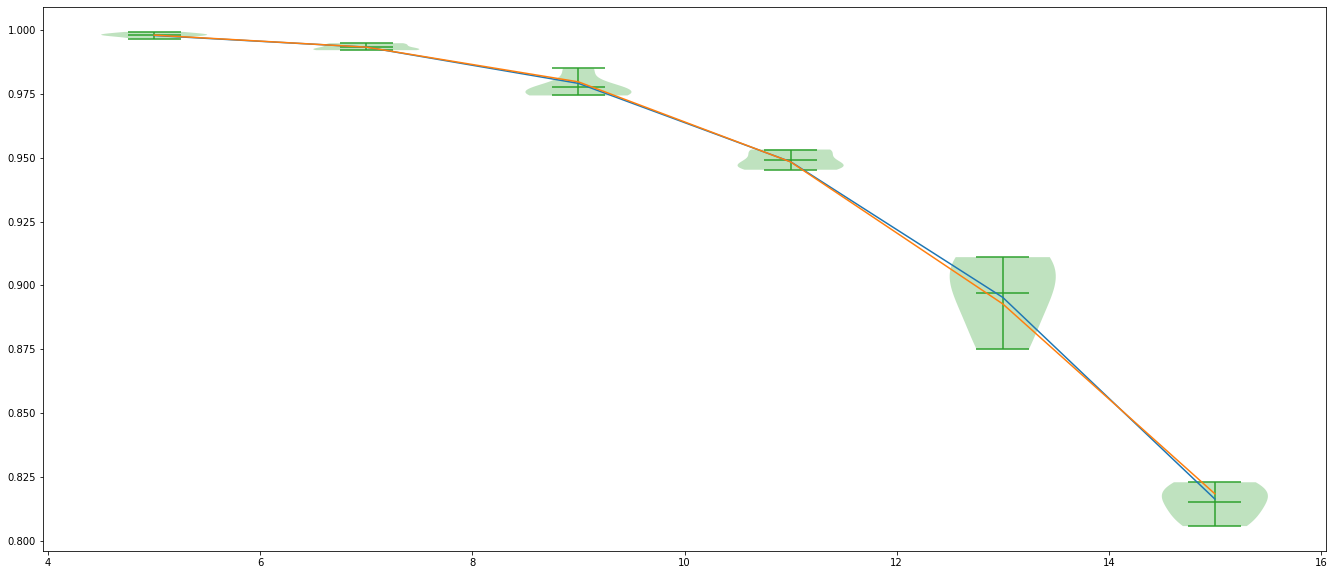

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

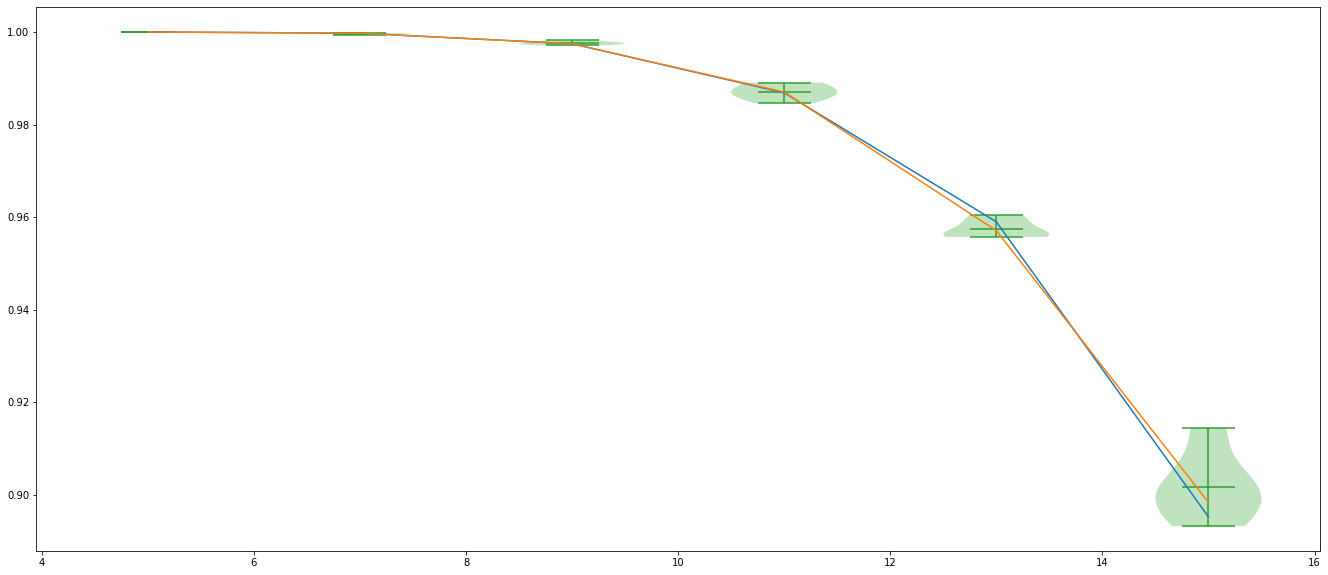

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

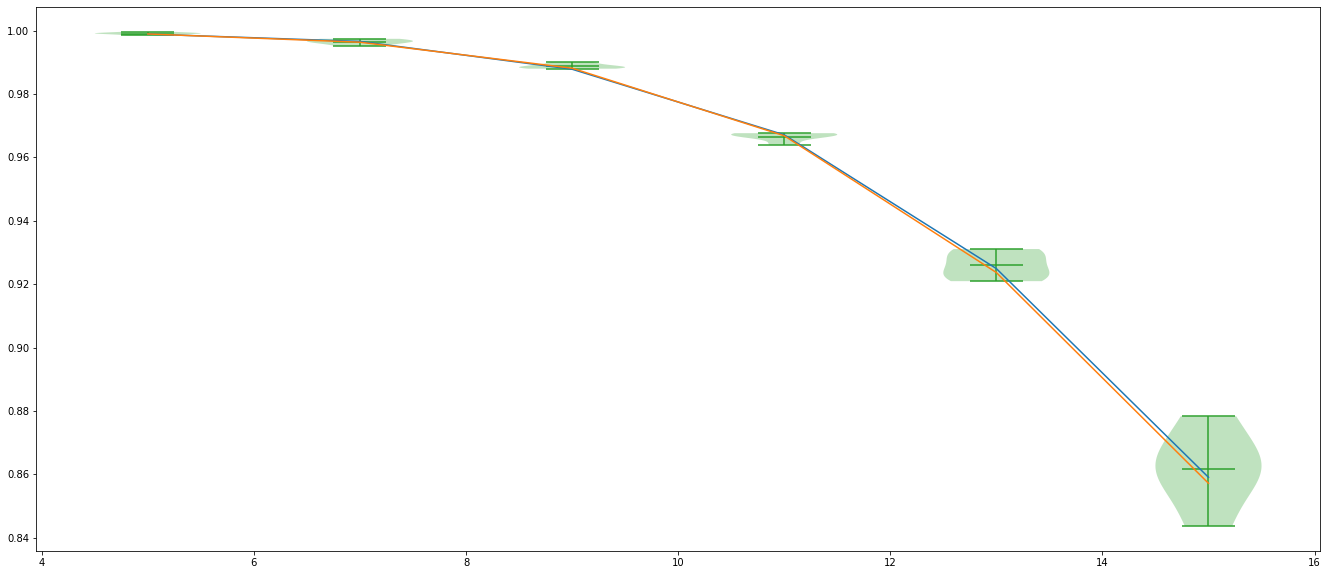

In [15]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

# Plots comparing times in the system (class 1)

1. Base plot
2. By adjusting $\mu$
3. By adjusting $k$
4. Using Hypoexponential (np.prod)
5. Using Hypoexponential (np.math.prod)

In [ ]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = None
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Simulation time in system VS Markov waiting times

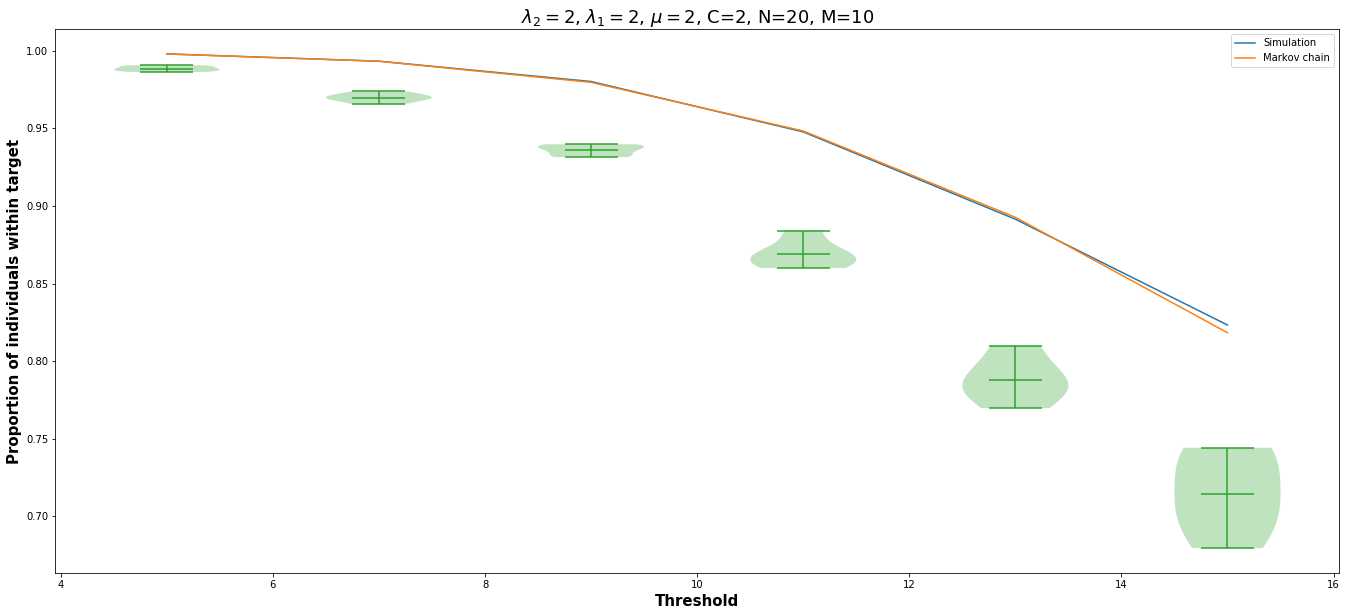

In [27]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (by adjusting $C\mu$ in $Erlang(k,C\mu)$)

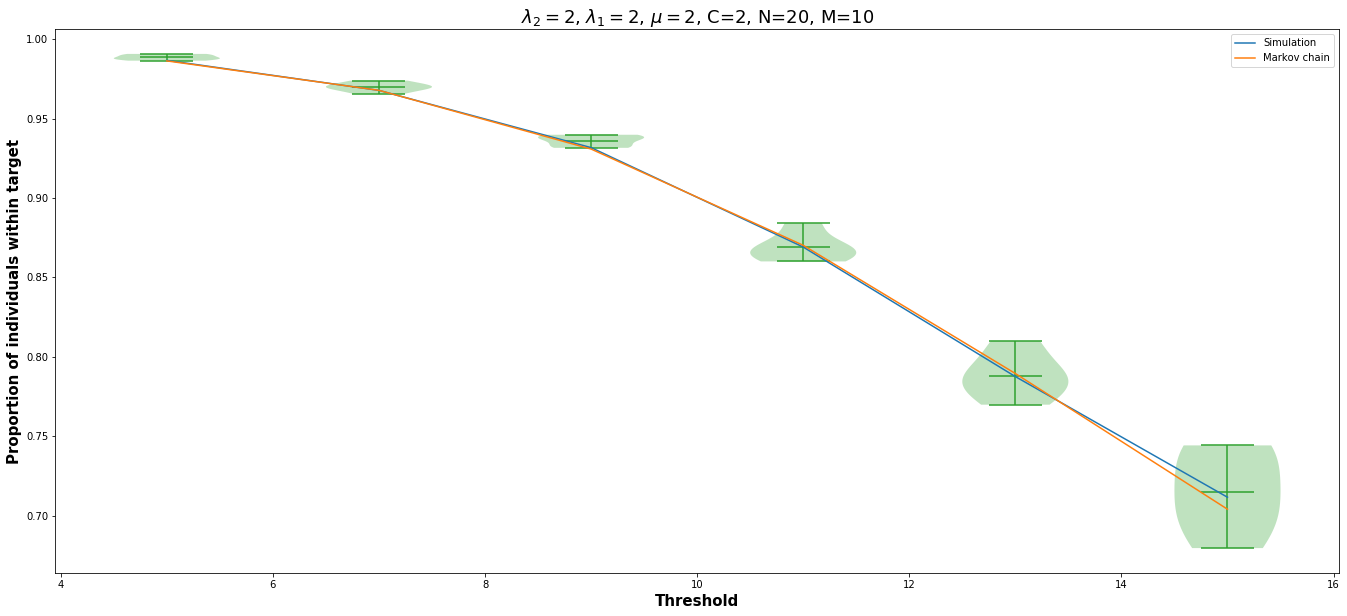

In [29]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (by adjusting $n$ in $Erlang(n,C\mu)$)

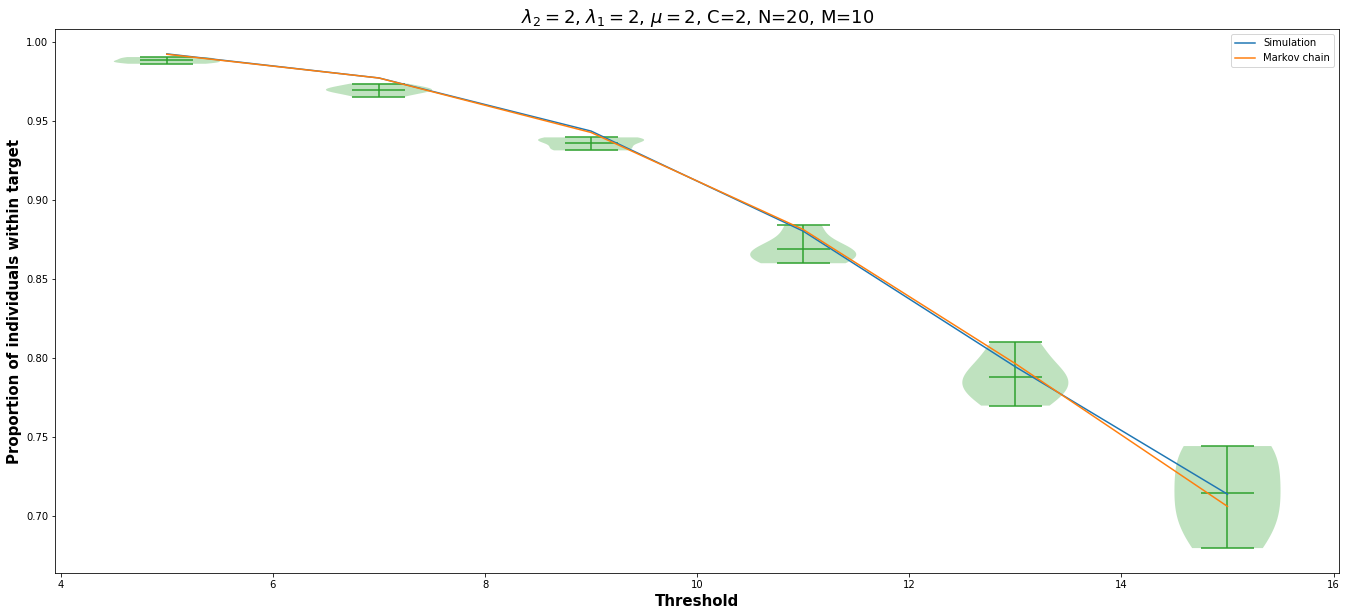

In [31]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (using $Hypo \sim (C\mu, \dots, C\mu, \mu)$ and numpy.prod())

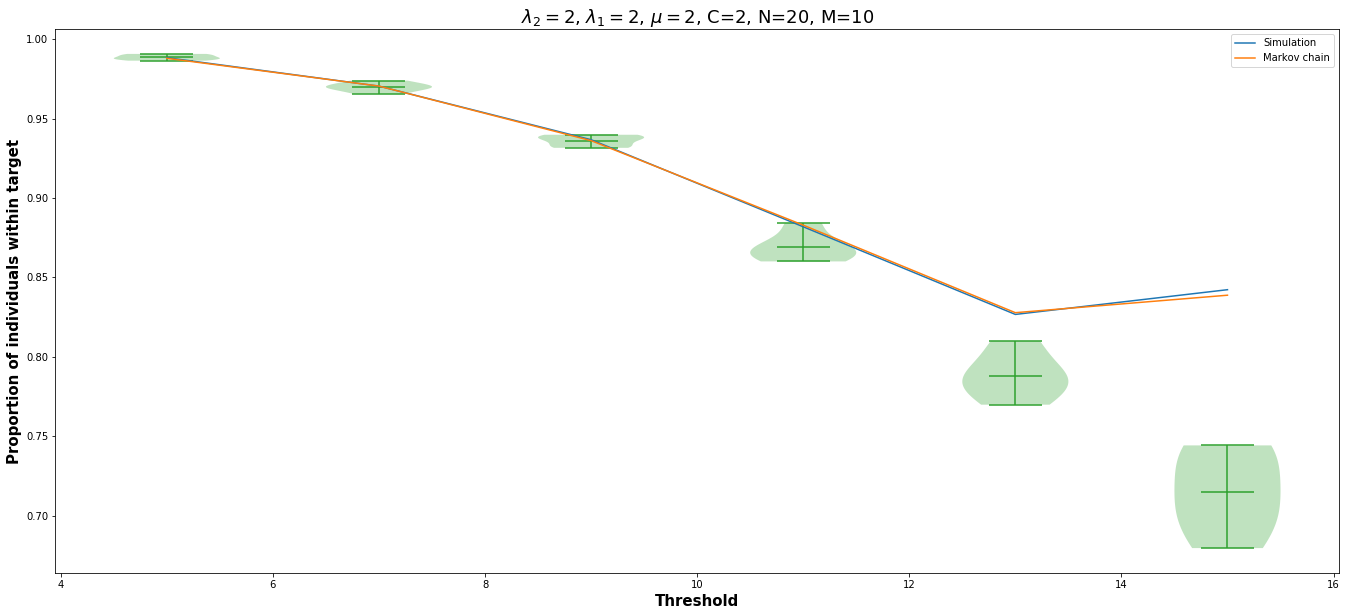

In [200]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Simulation time in system VS Markov time in system (using $Hypo \sim (C\mu, \dots, C\mu, \mu)$ and numpy.math.prod())

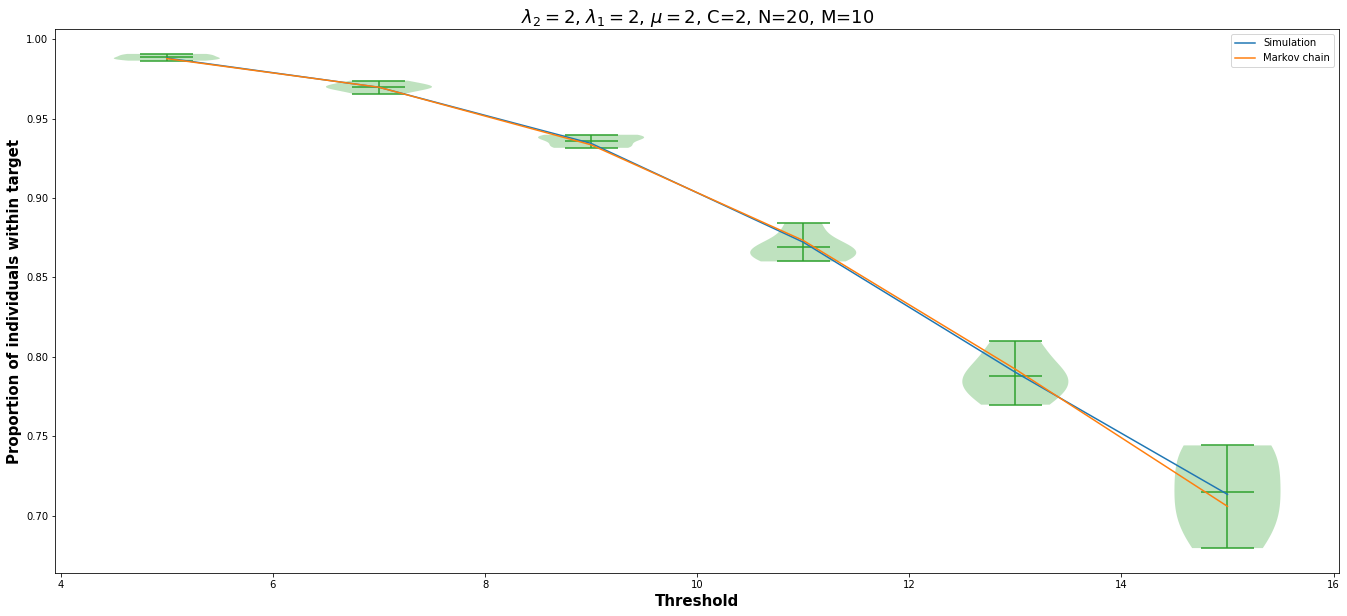

In [187]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=1,
    num_of_trials=num_of_trials,
    runtime=10000,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

# Plots comparing times in the system (using non-linear cdf of Hypo.)

## $\lambda_1 = 2, \lambda_2 = 2, \mu = 2, C = 2, T_{\min} = 5, T_{\max} = 15, N = 20, M = 10$

In [21]:
lambda_1 = 2
lambda_2 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = 0
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Class 1

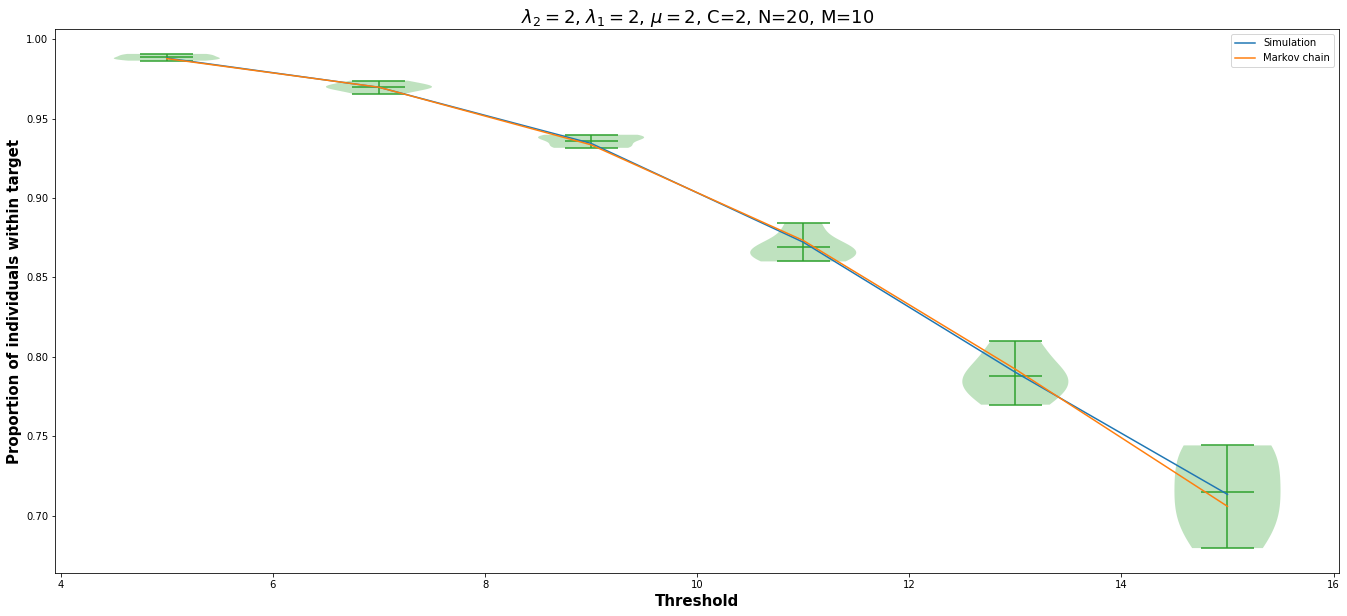

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

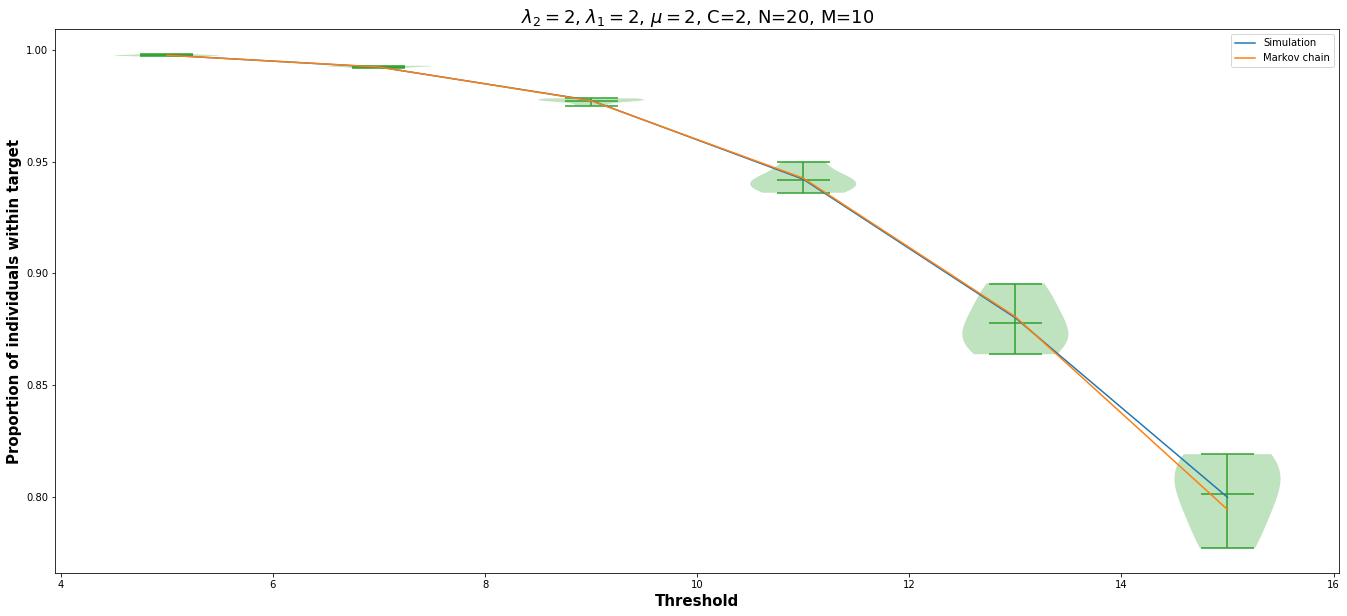

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

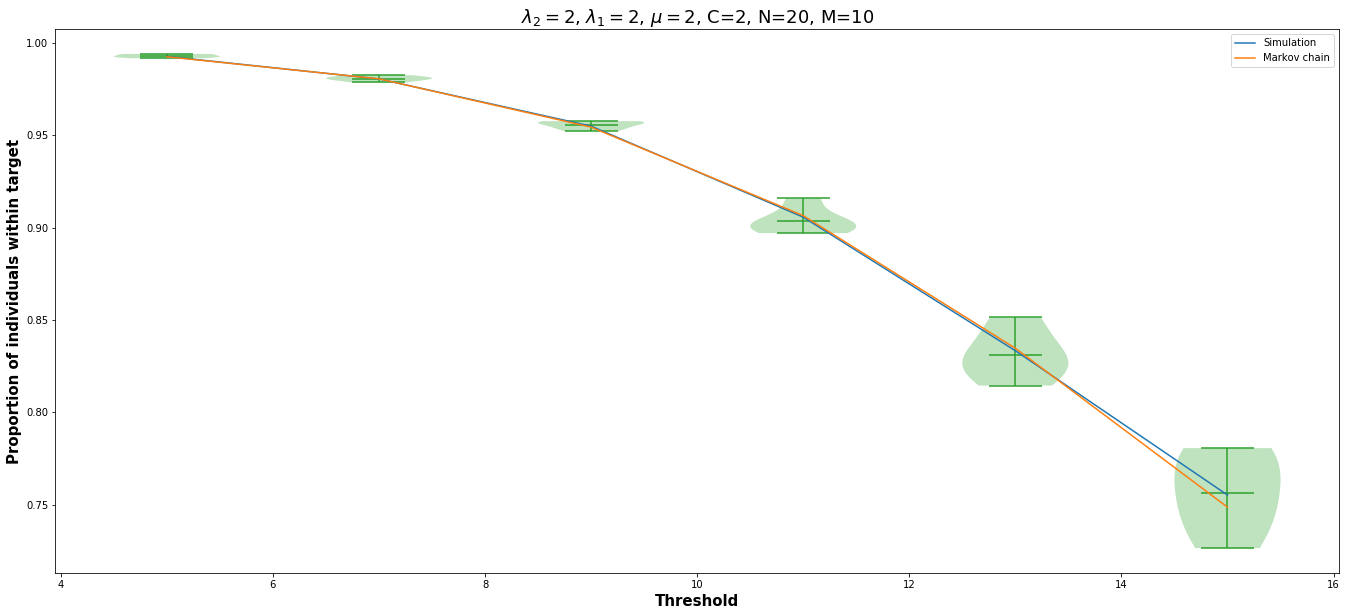

In [24]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 10, M = 10$

In [81]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 10
buffer_capacity = 10

seed_num = 1
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

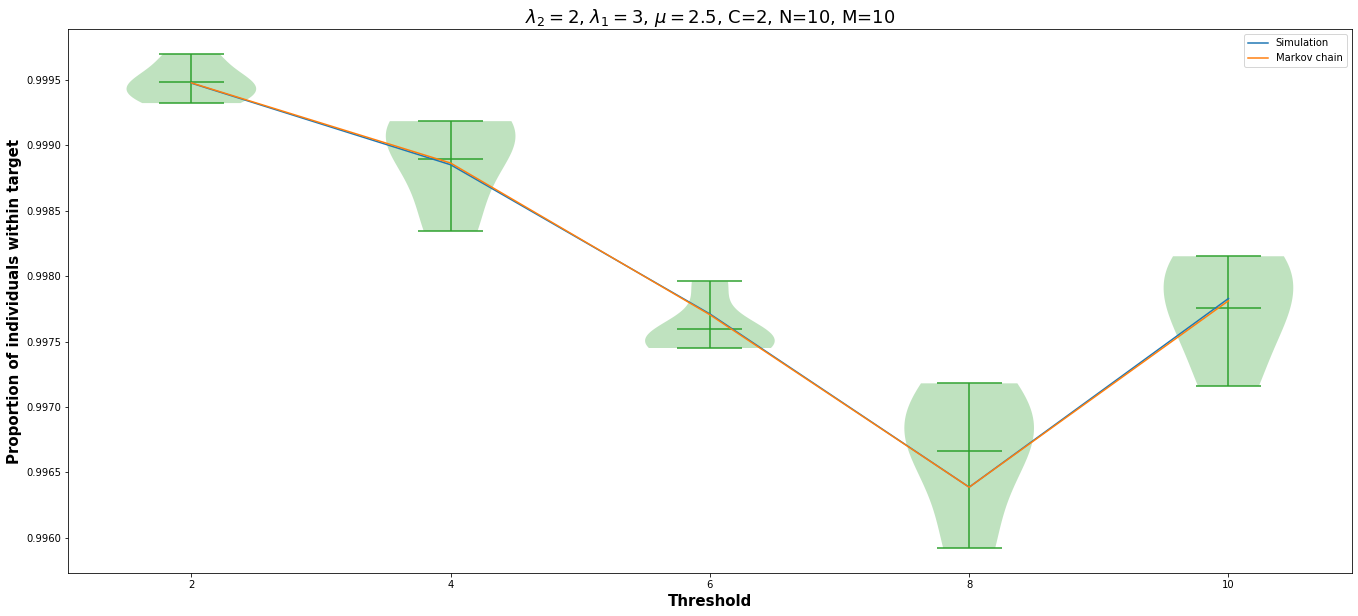

In [83]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

### General behaviour of $P(W_1 > target)$
- As the threshold increases the waiting time of class 1 patients should increase.
- As the waiting time of class 1 patients increases $P(W_1 < target)$ should decrease.
- $\Rightarrow$ As the threshold increases $P(W_1 < target)$ should decrease.

### **BUT** as the threshold gets close to the system capacity:
- Class 2 patients can take up more waiting spaces
- Class 1 patients get more frequently lost to the system
- Average waiting time of class 1 patients decreases
- As $W_1$ decreases $P(W_1 < target)$ increases

## Class 2

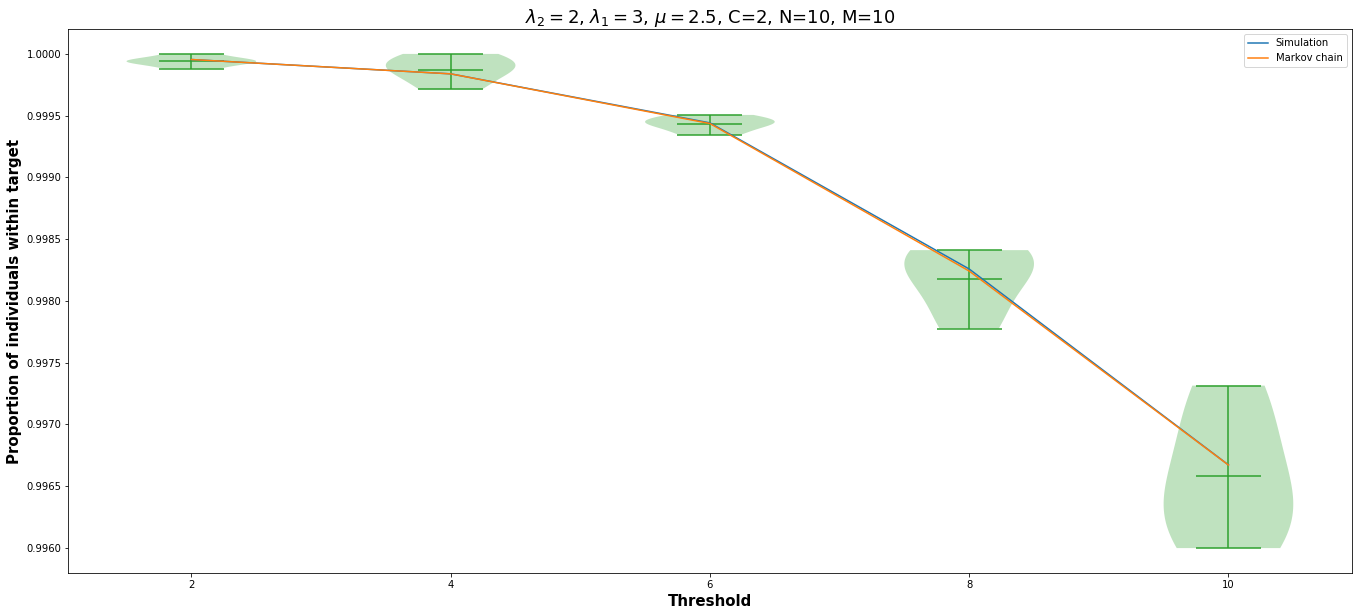

In [84]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

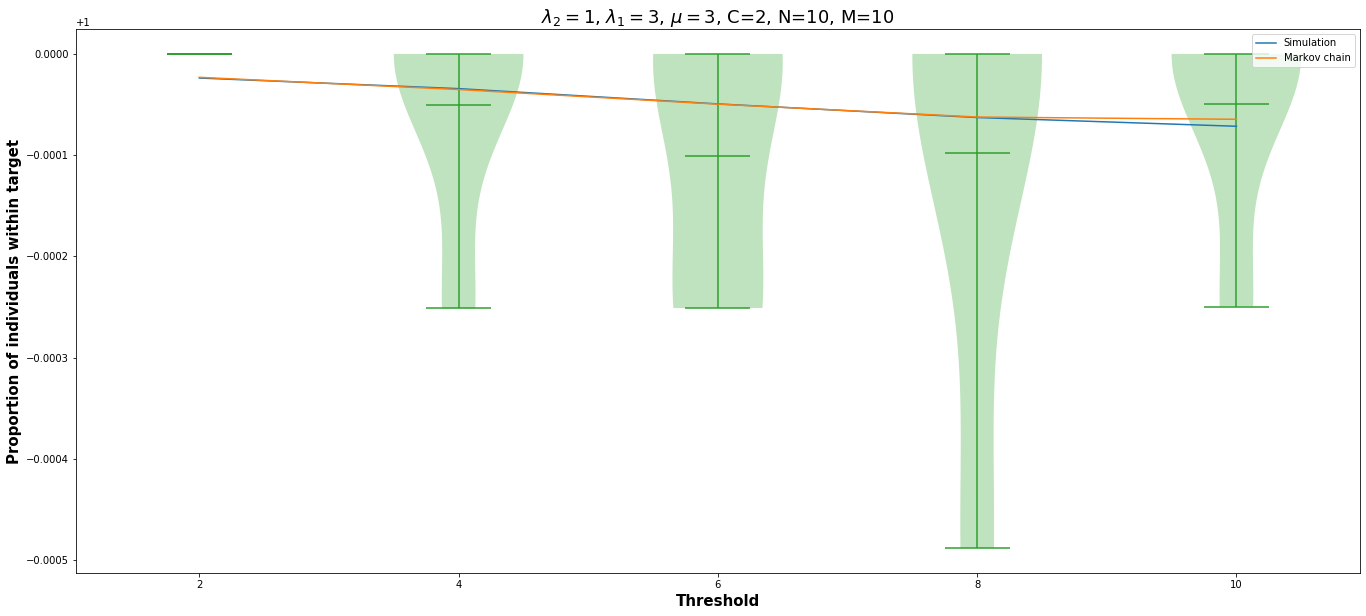

In [34]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 20, M = 10$

In [20]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

seed_num = 2
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

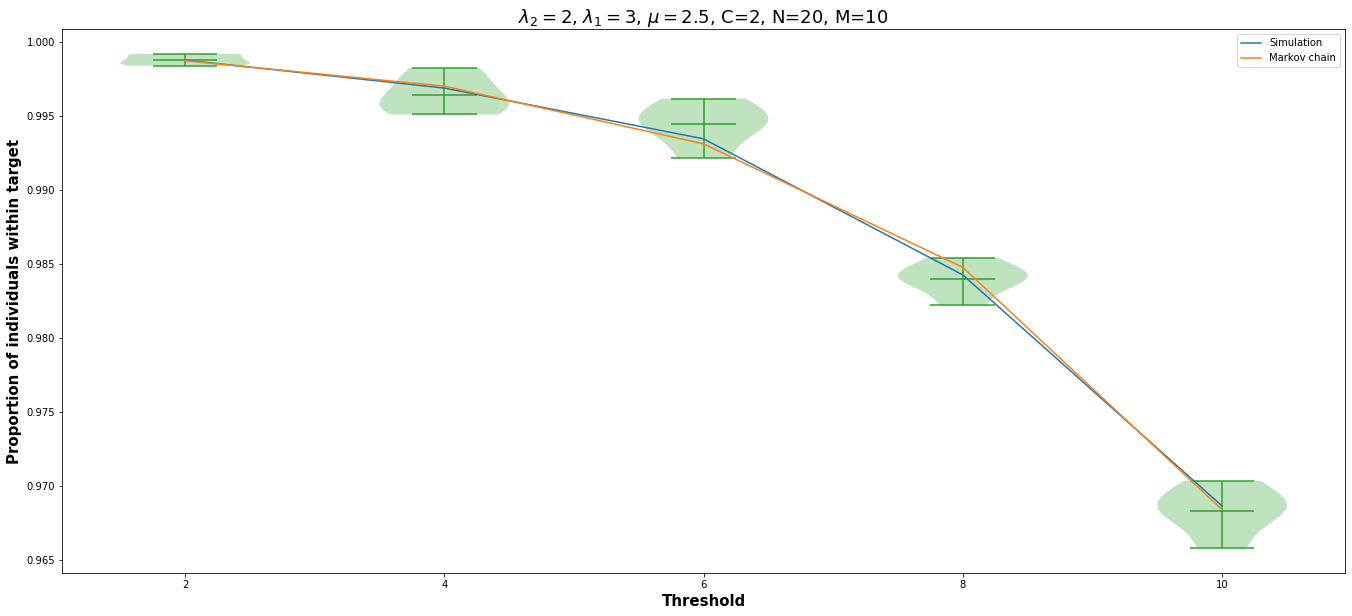

In [21]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

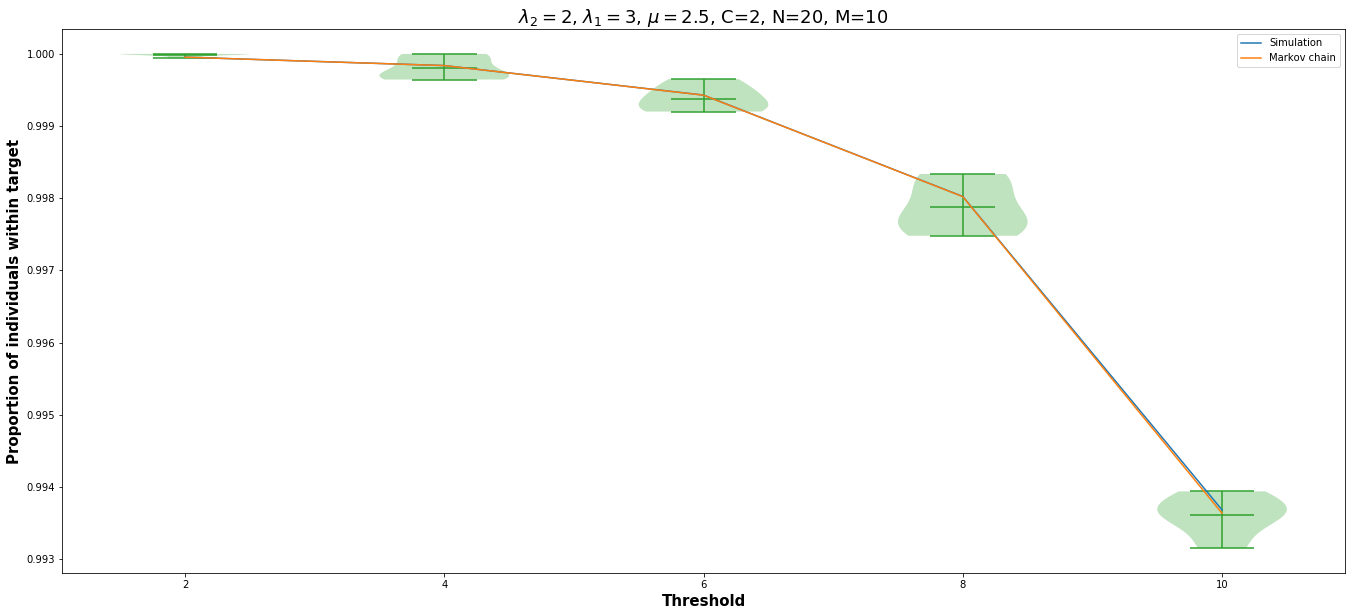

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

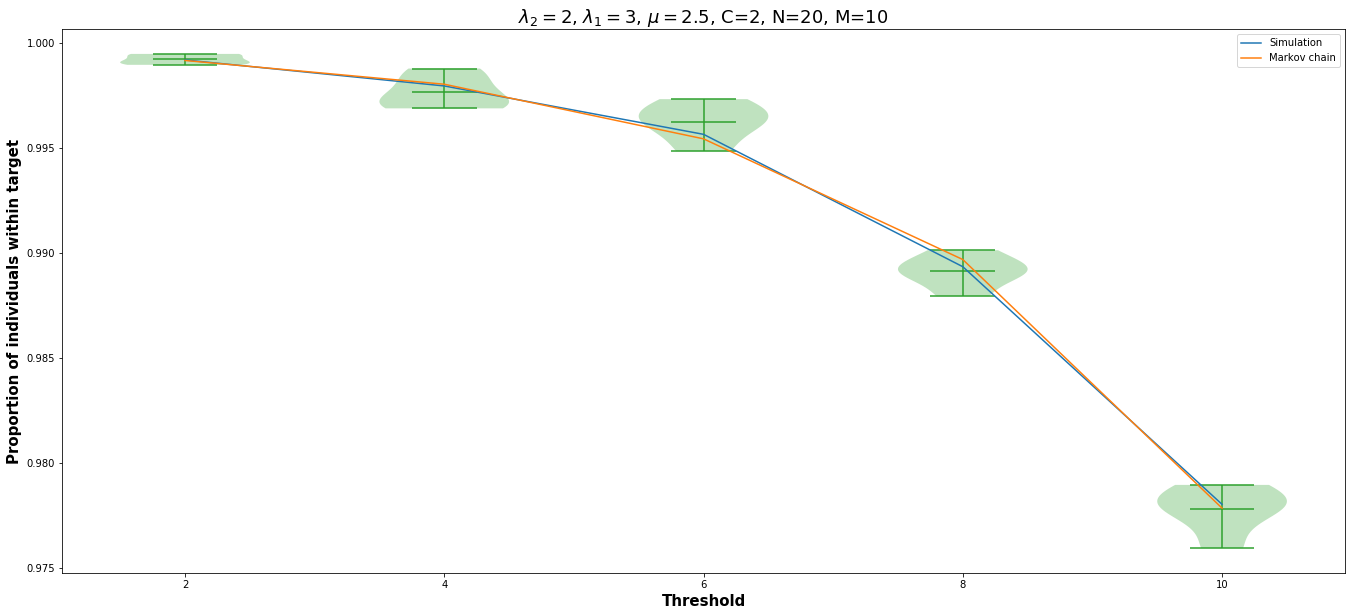

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = \frac{1}{2}, \lambda_2 = \frac{1}{2}, \mu = \frac{1}{2}, C = 3, T_{\min} = 2, T_{\max} = 6, N = 6, M = 5$

In [30]:
lambda_1 = 0.5
lambda_2 = 0.5
mu = 0.5

num_of_servers = 3
system_capacity = 6
buffer_capacity = 5

seed_num = 3
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 6
accuracy = 5
target = 4

## Class 1

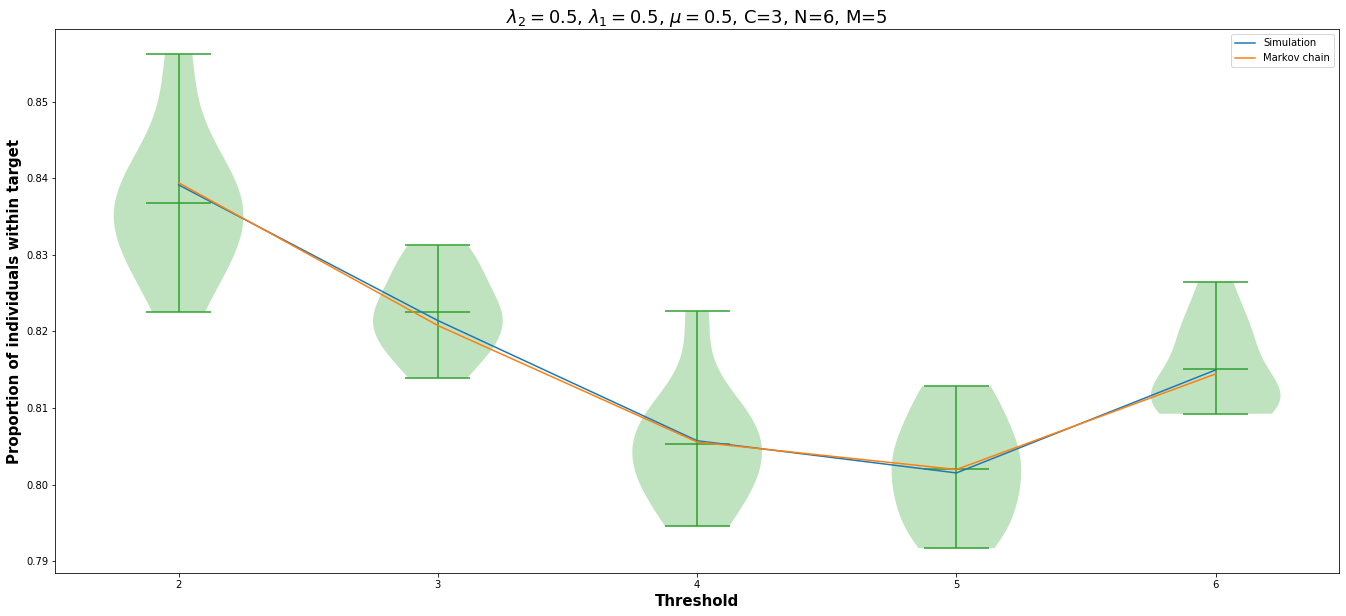

In [31]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

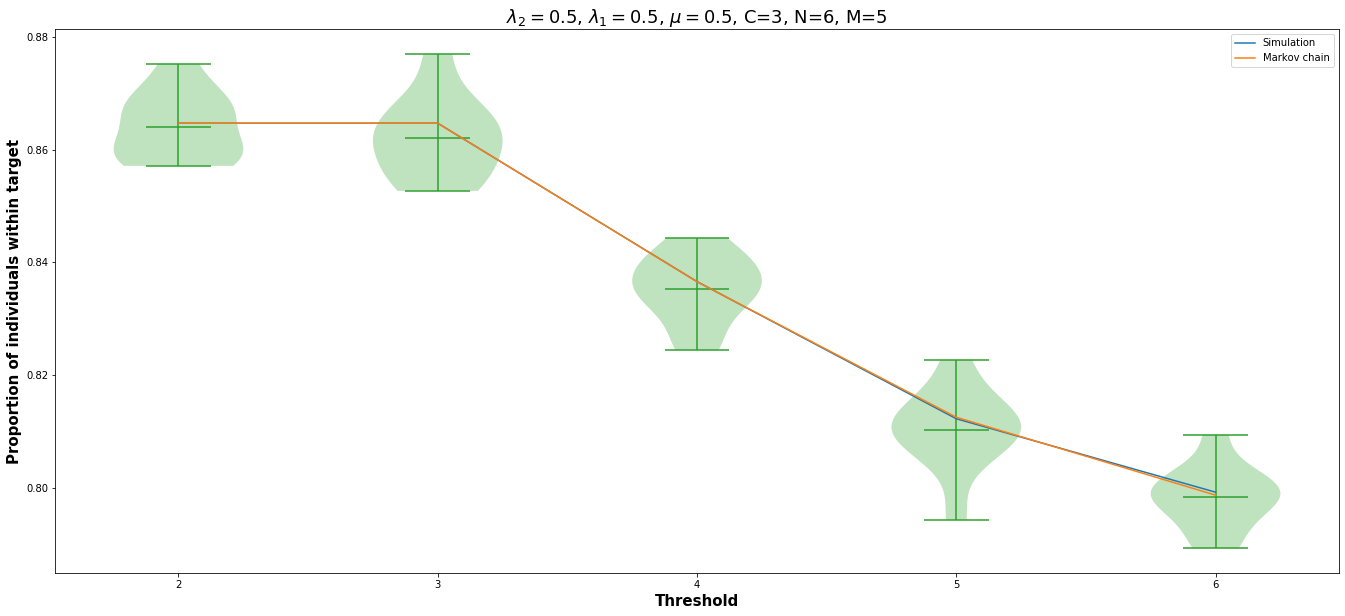

In [32]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

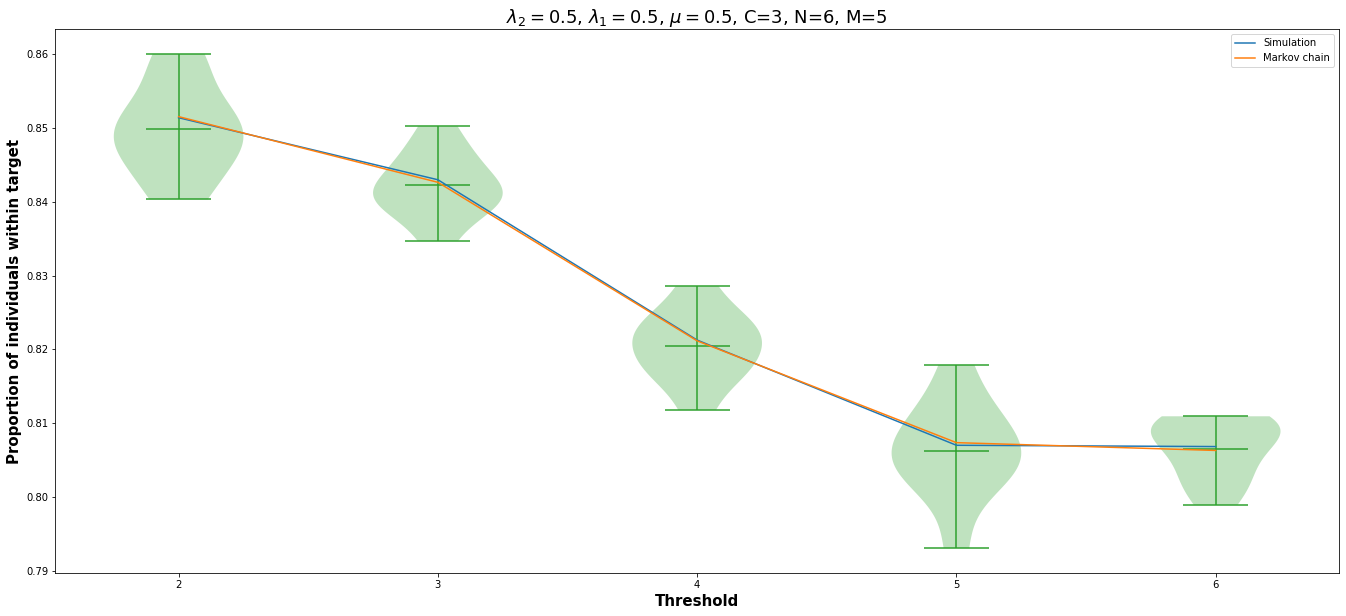

In [33]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 1, \lambda_2 = 2, \mu = 4, C = 1, T_{\min} = 2, T_{\max} = 10, N = 15, M = 15$

In [18]:
lambda_1 = 1
lambda_2 = 2
mu = 4

num_of_servers = 1
system_capacity = 15
buffer_capacity = 15

seed_num = None
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

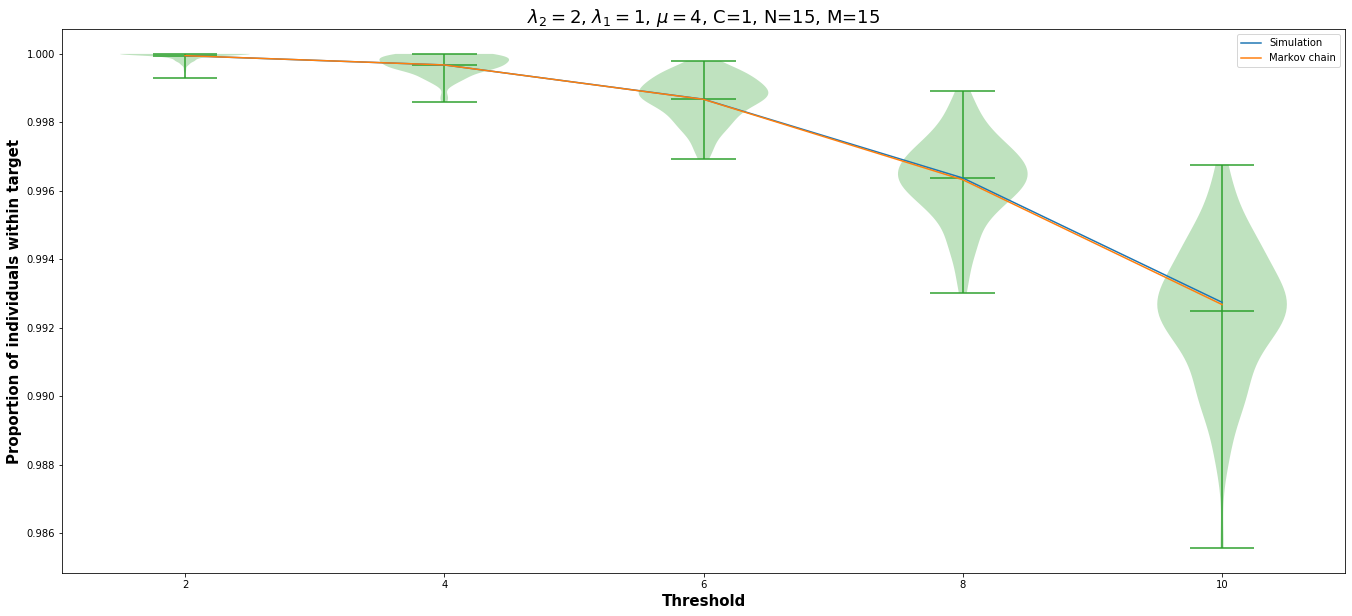

In [38]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

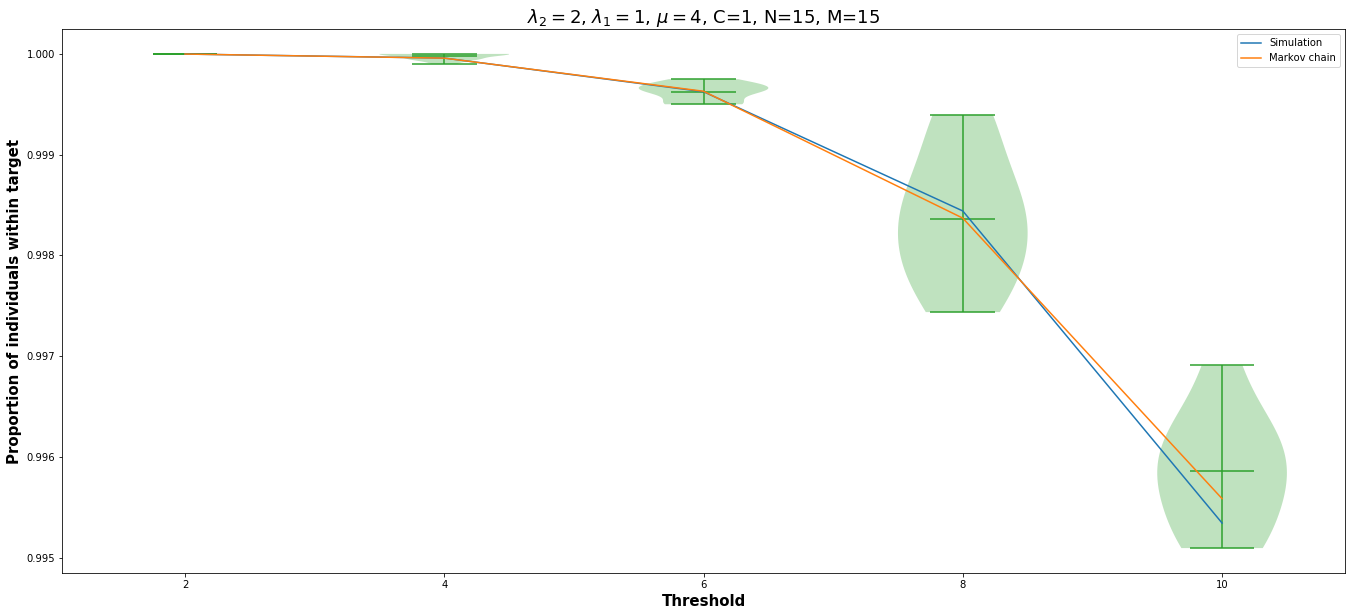

In [19]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes 

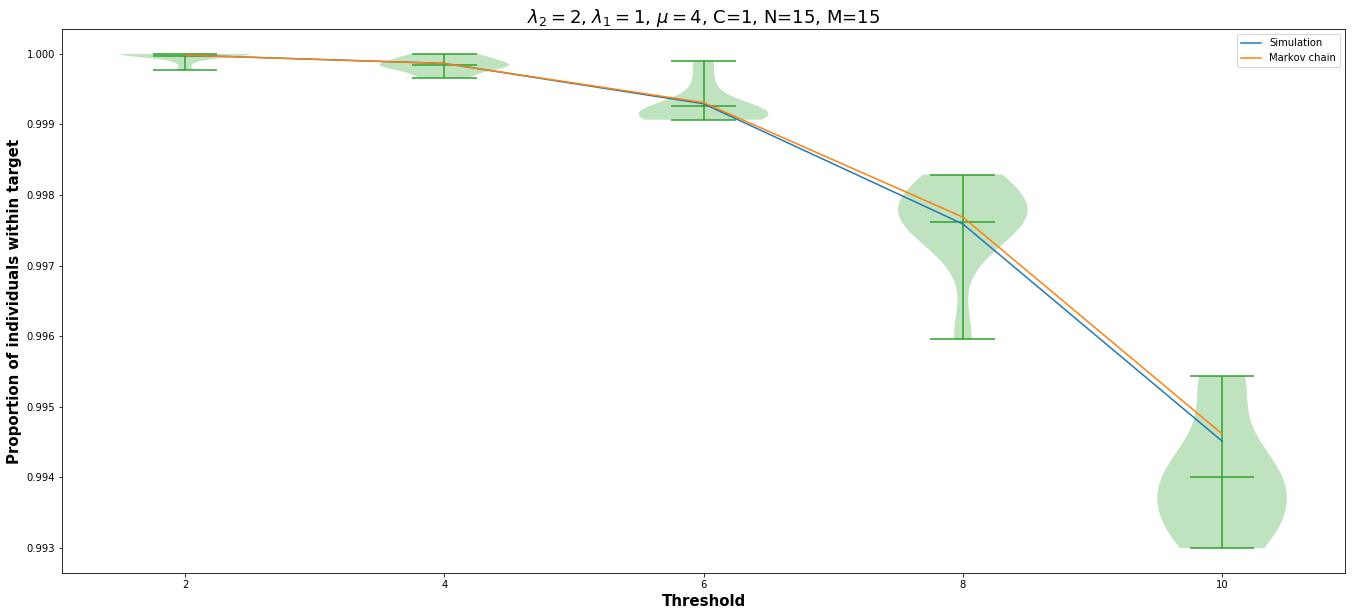

In [20]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

# Plots comparing times in the system (linear Hypo. formula)

## $\lambda_1 = 2, \lambda_2 = 2, \mu = 2, C = 2, T_{\min} = 5, T_{\max} = 15, N = 20, M = 10$

In [51]:
lambda_1 = 2
lambda_2 = 2
mu = 2

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = 0
num_of_trials = 5
runtime = 10000

min_threshold = 5
max_threshold = 15
accuracy = 6

## Class 1

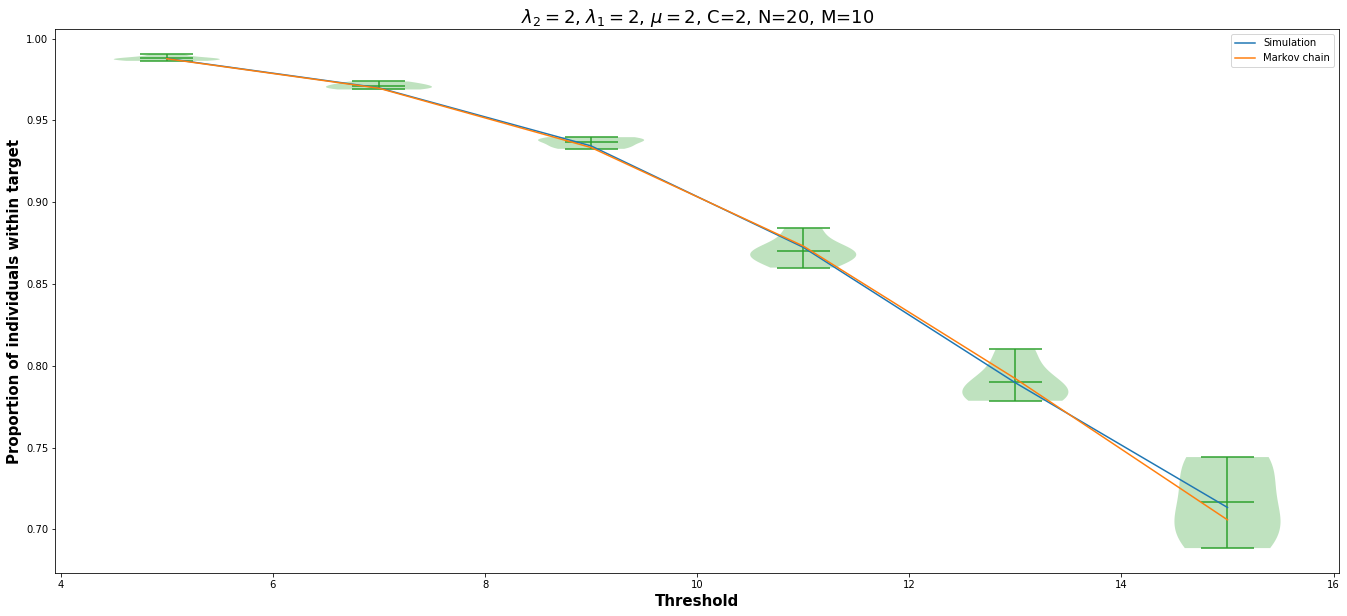

In [52]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

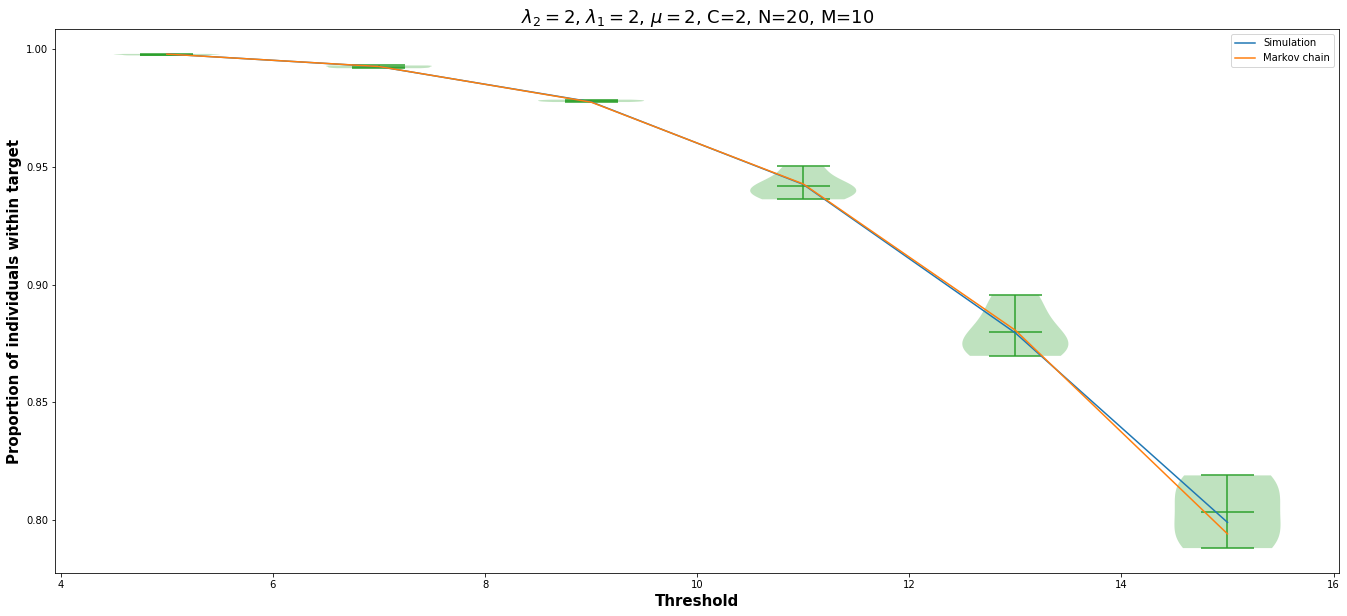

In [53]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

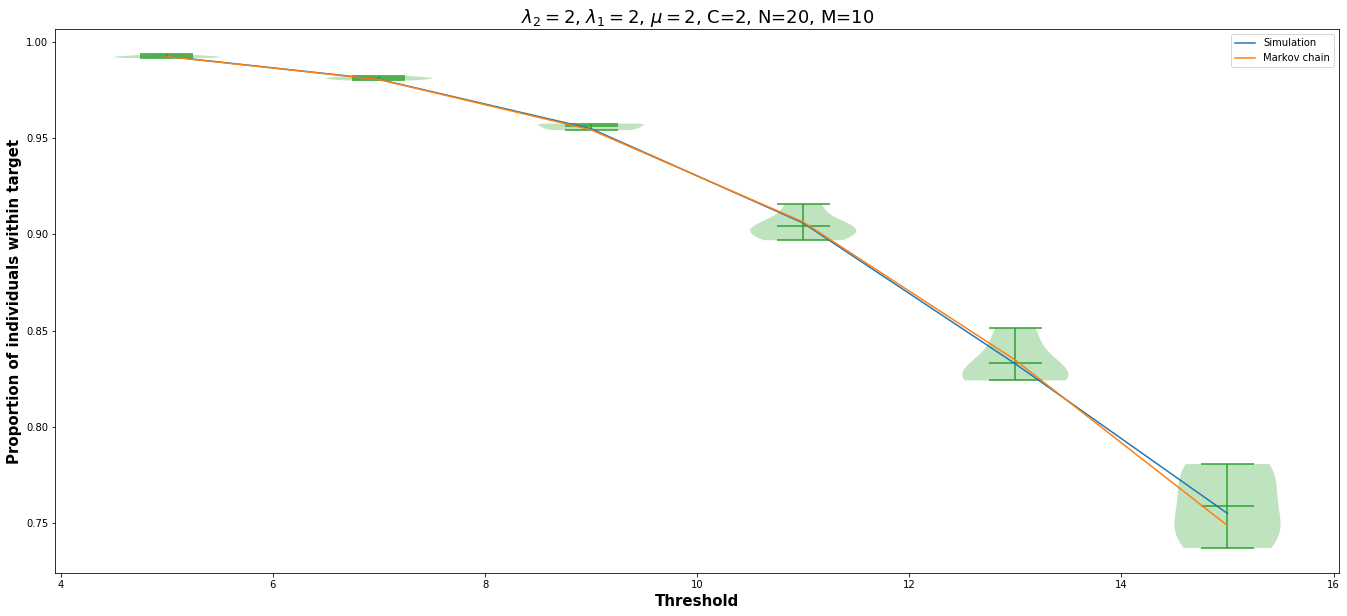

In [54]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 10, M = 10$

In [55]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 10
buffer_capacity = 10

seed_num = 1
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

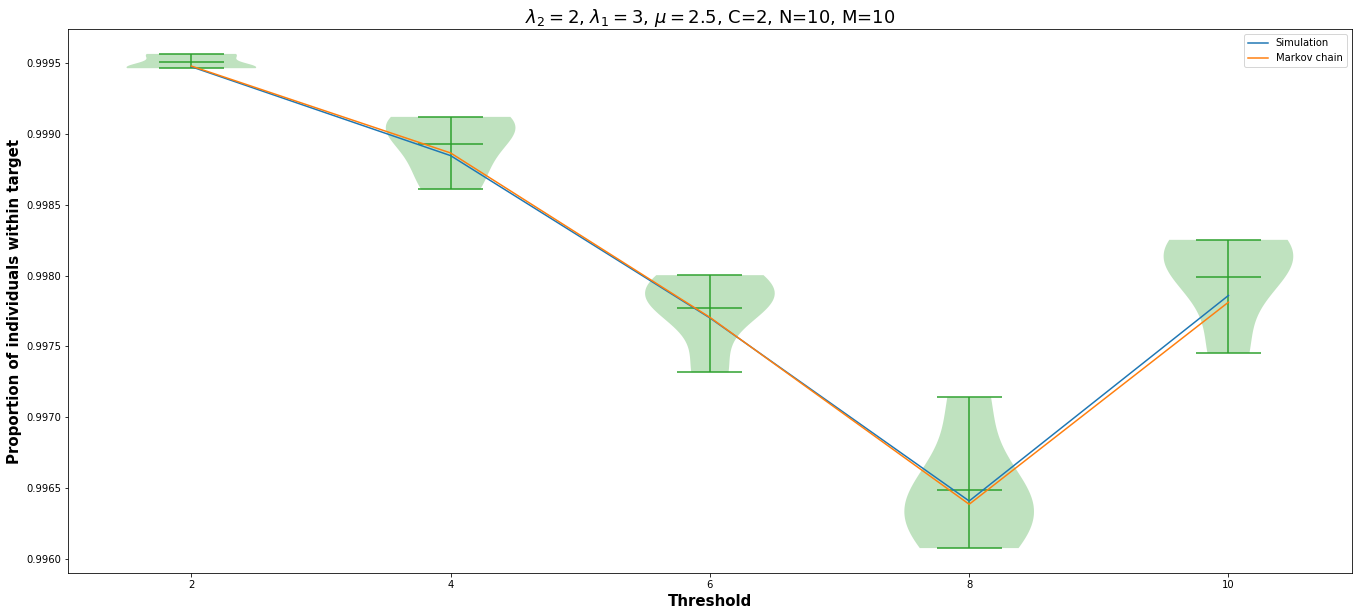

In [56]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

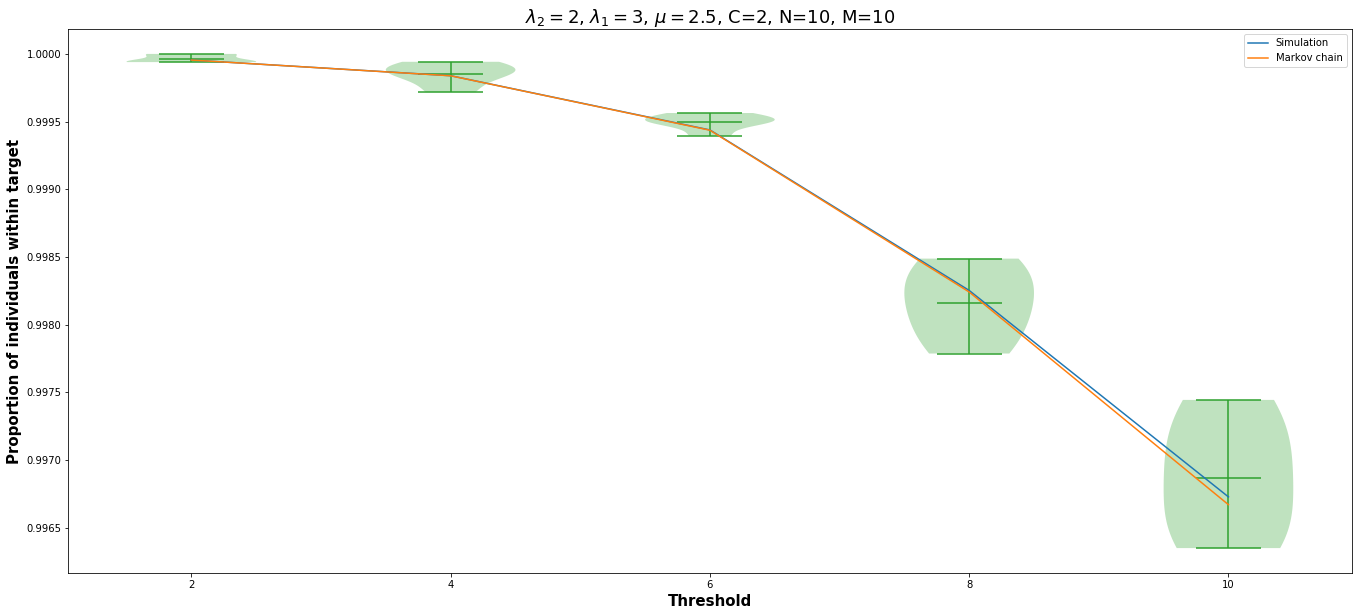

In [57]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

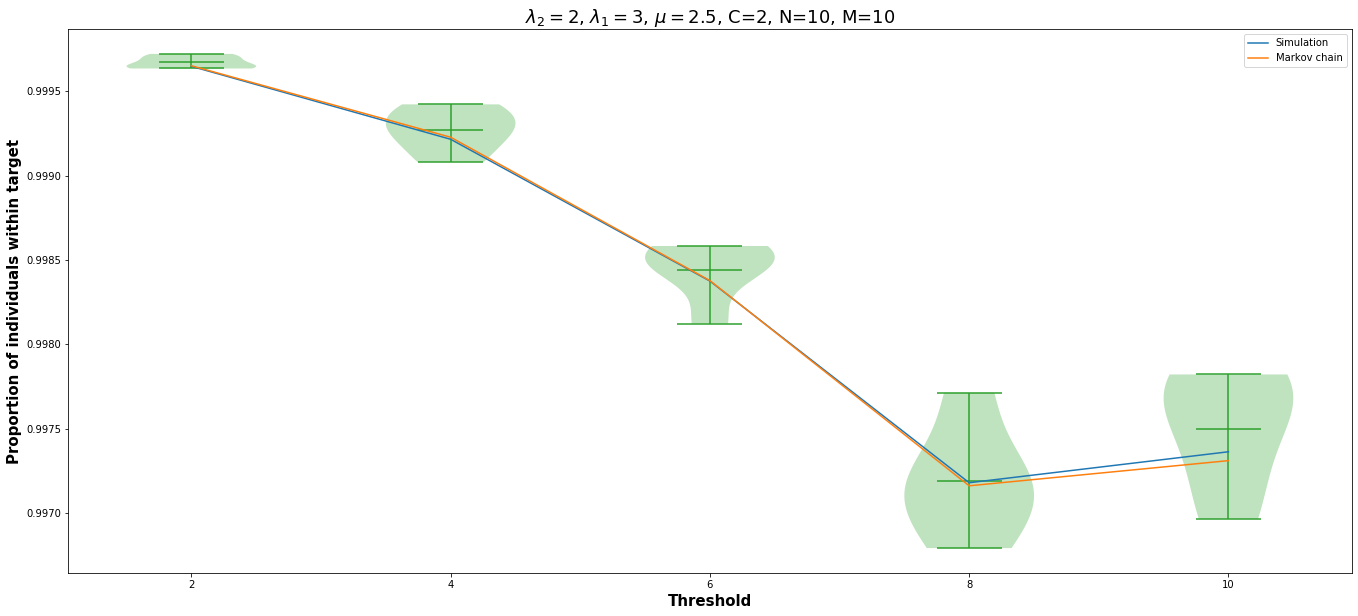

In [58]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 3, \lambda_2 = 2, \mu = 2.5, C = 2, T_{\min} = 2, T_{\max} = 10, N = 20, M = 10$

In [59]:
lambda_1 = 3
lambda_2 = 2
mu = 2.5

num_of_servers = 2
system_capacity = 20
buffer_capacity = 10

seed_num = 2
num_of_trials = 5
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

## Class 1

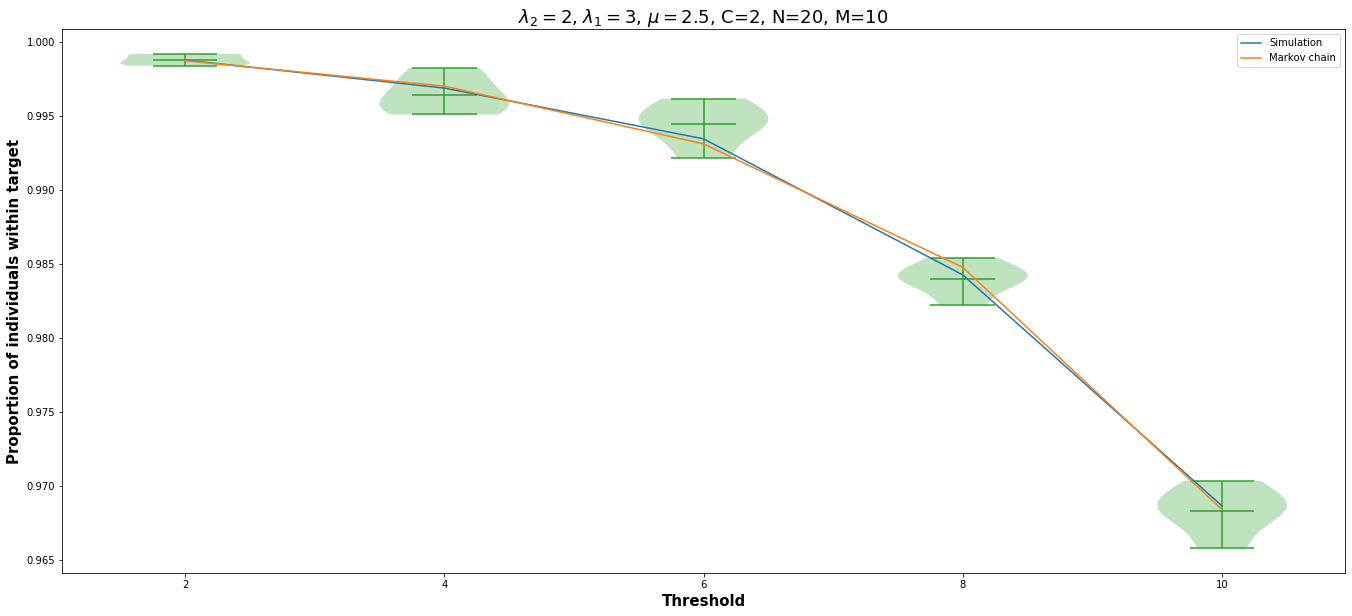

In [60]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

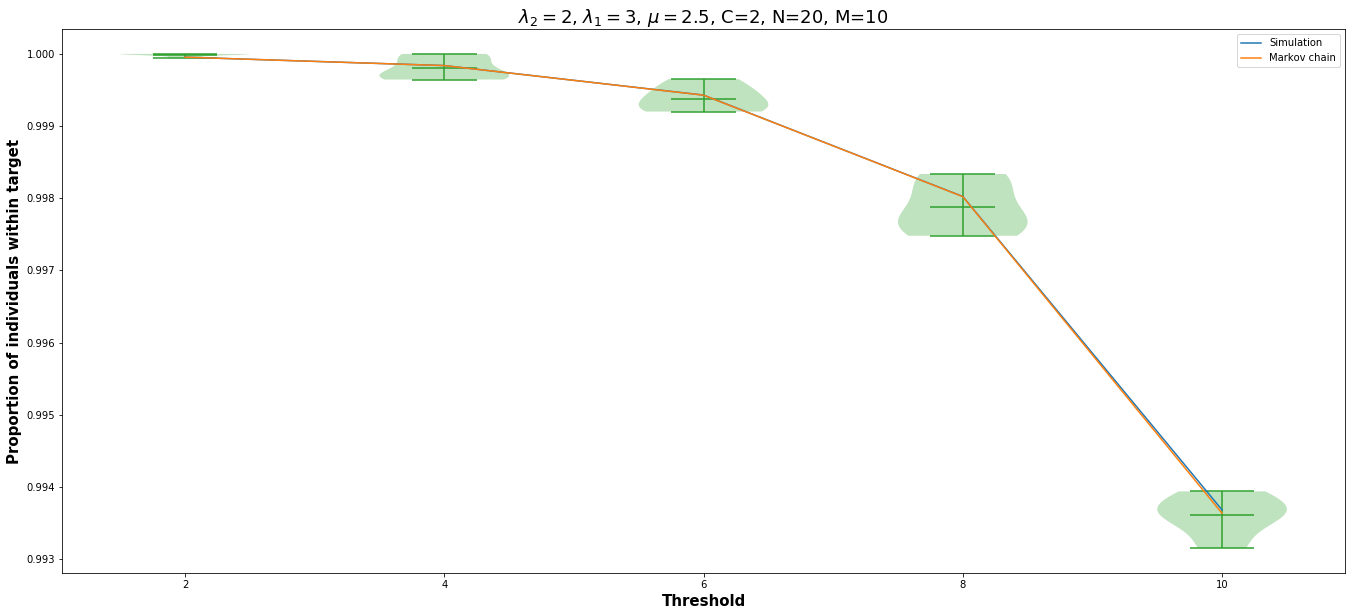

In [61]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

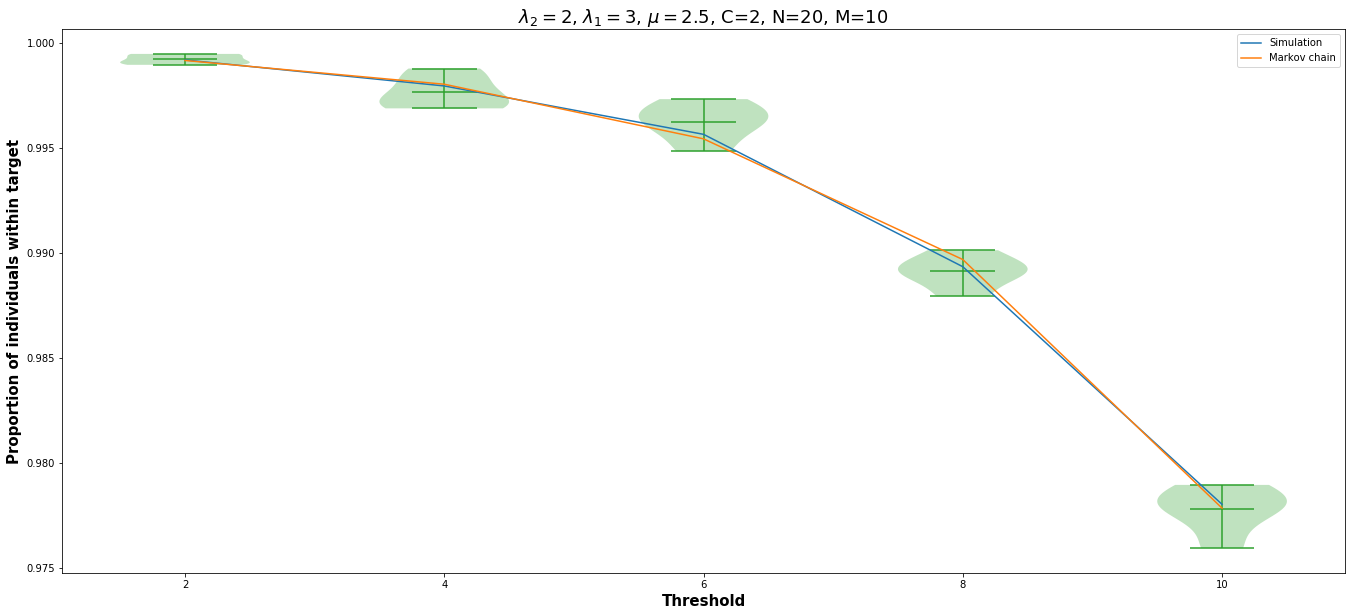

In [62]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = \frac{1}{2}, \lambda_2 = \frac{1}{2}, \mu = \frac{1}{2}, C = 3, T_{\min} = 2, T_{\max} = 6, N = 6, M = 5$

In [63]:
lambda_1 = 0.5
lambda_2 = 0.5
mu = 0.5

num_of_servers = 3
system_capacity = 6
buffer_capacity = 5

seed_num = 3
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 6
accuracy = 5
target = 4

## Class 1

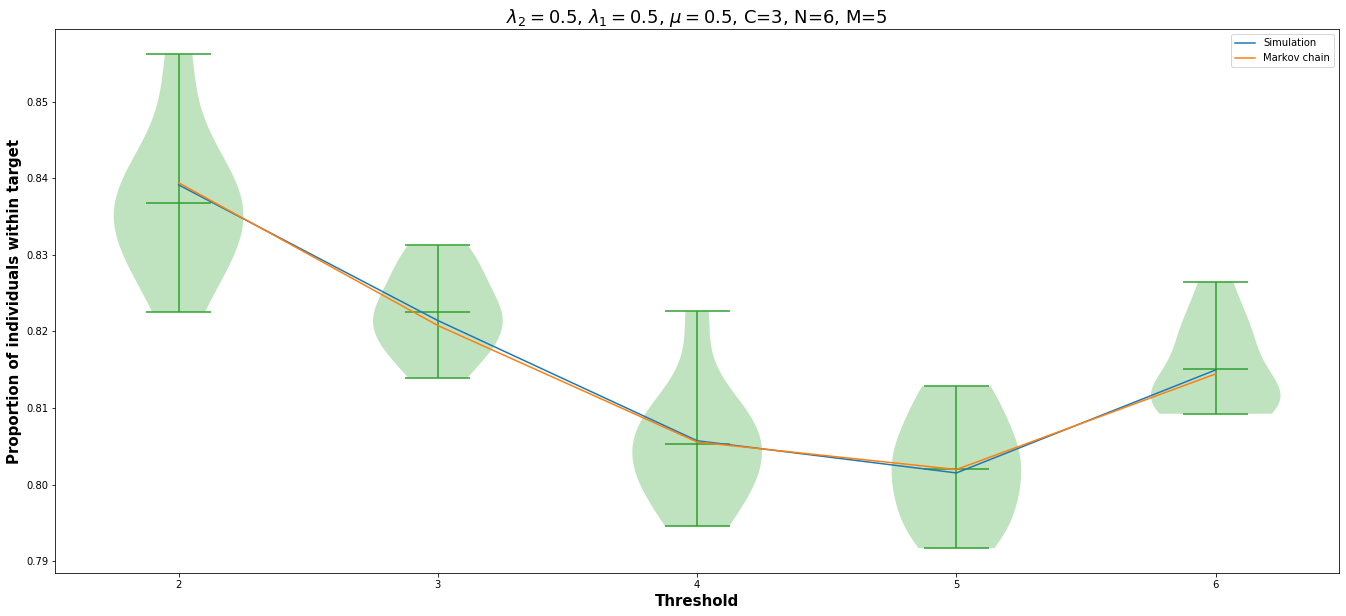

In [64]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

## Class 2

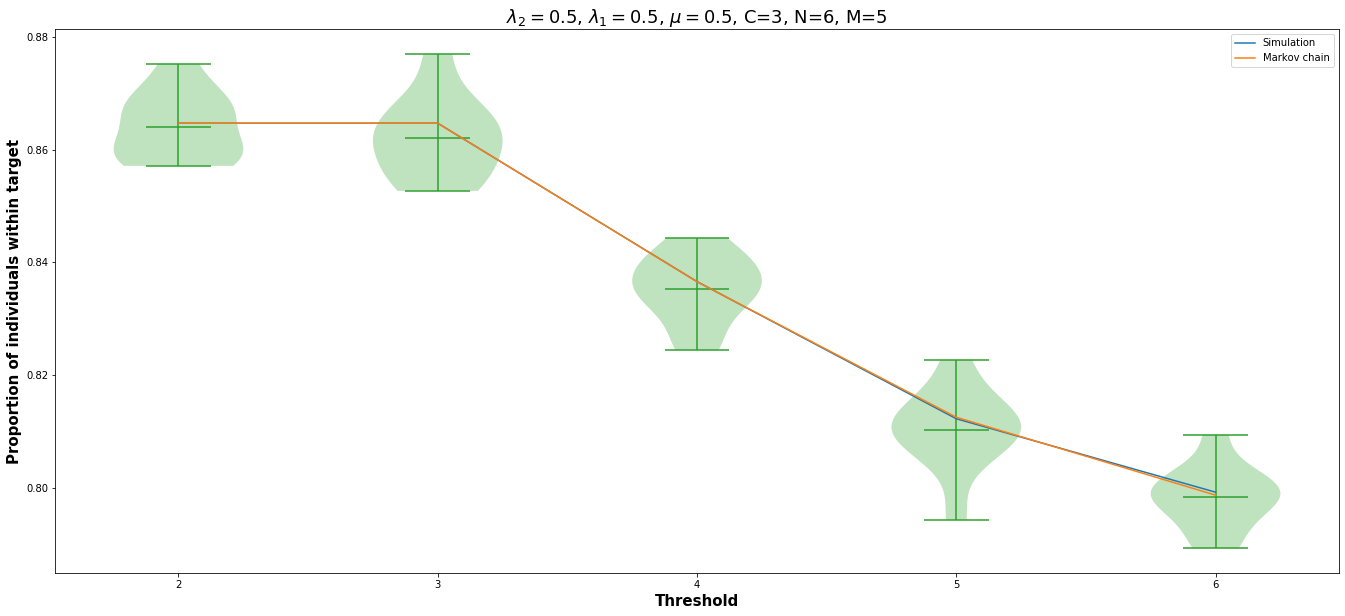

In [65]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

## Both classes

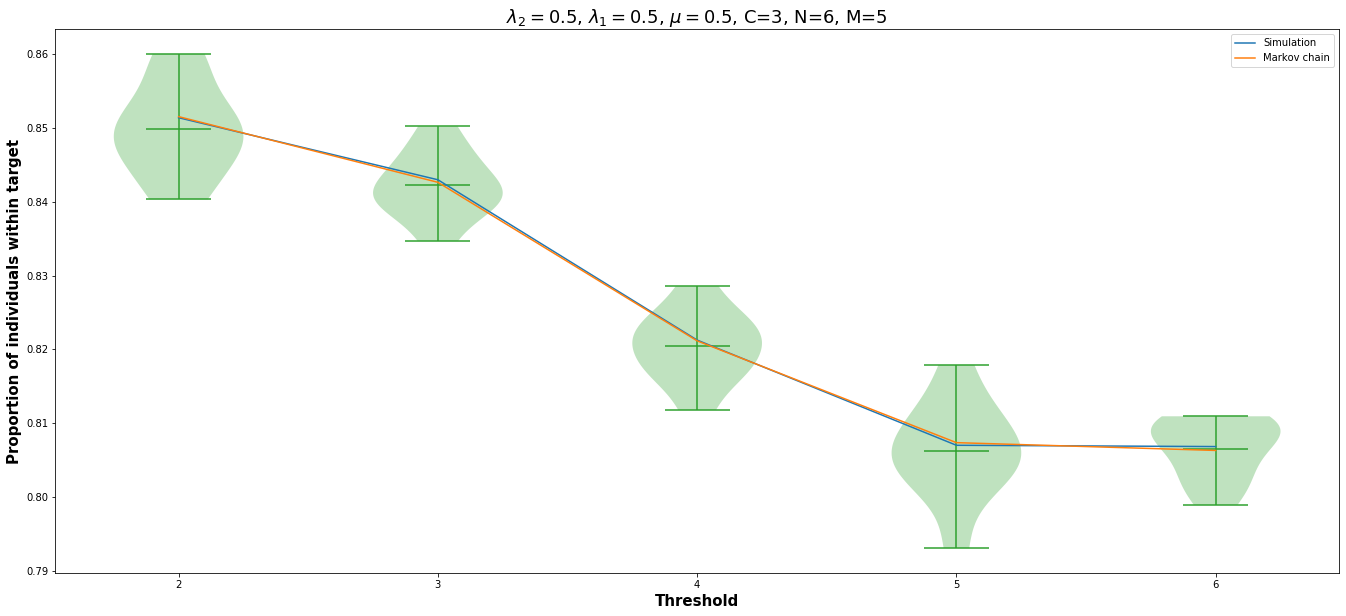

In [66]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)

## $\lambda_1 = 1, \lambda_2 = 2, \mu = 4, C = 1, T_{\min} = 2, T_{\max} = 10, N = 15, M = 15$

In [67]:
lambda_1 = 1
lambda_2 = 2
mu = 4

num_of_servers = 1
system_capacity = 15
buffer_capacity = 15

seed_num = None
num_of_trials = 10
runtime = 10000

min_threshold = 2
max_threshold = 10
accuracy = 5
target = 4

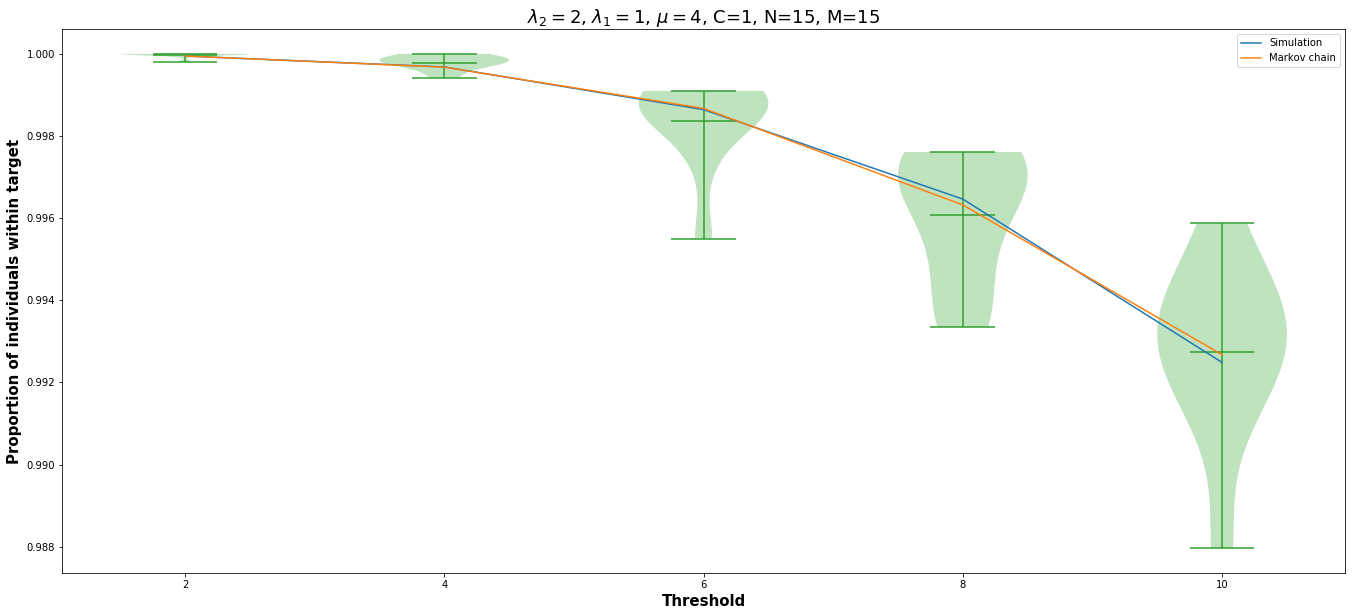

In [68]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    accuracy=accuracy,
)

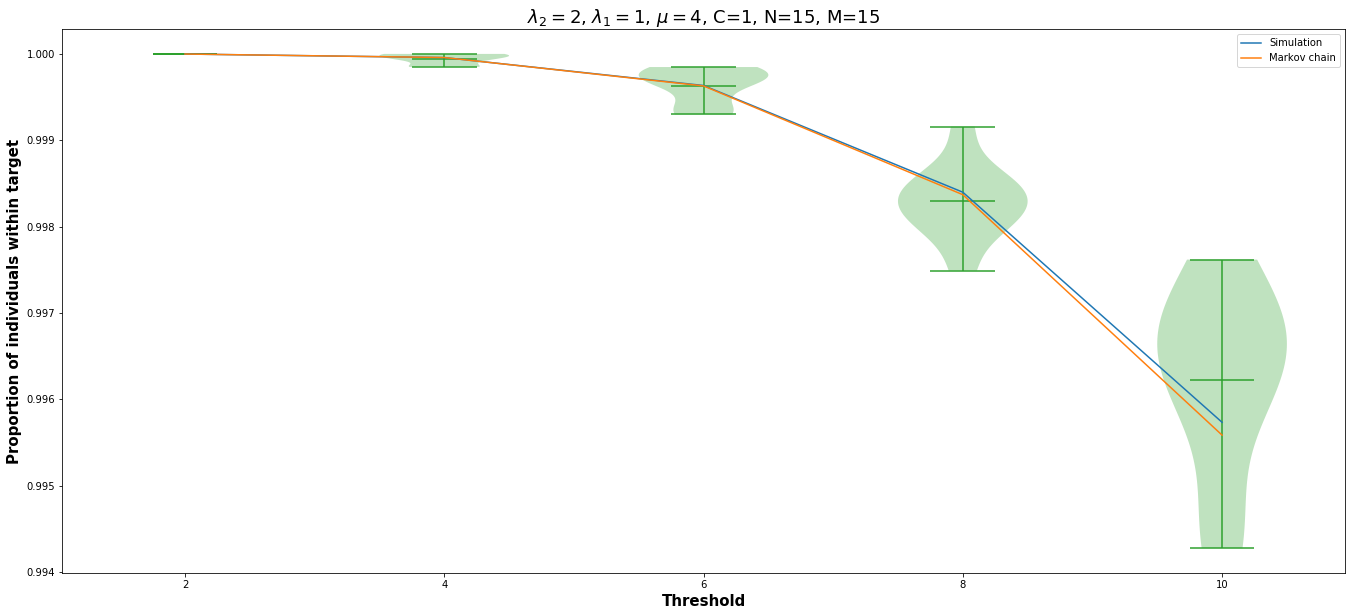

In [69]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    accuracy=accuracy,
)

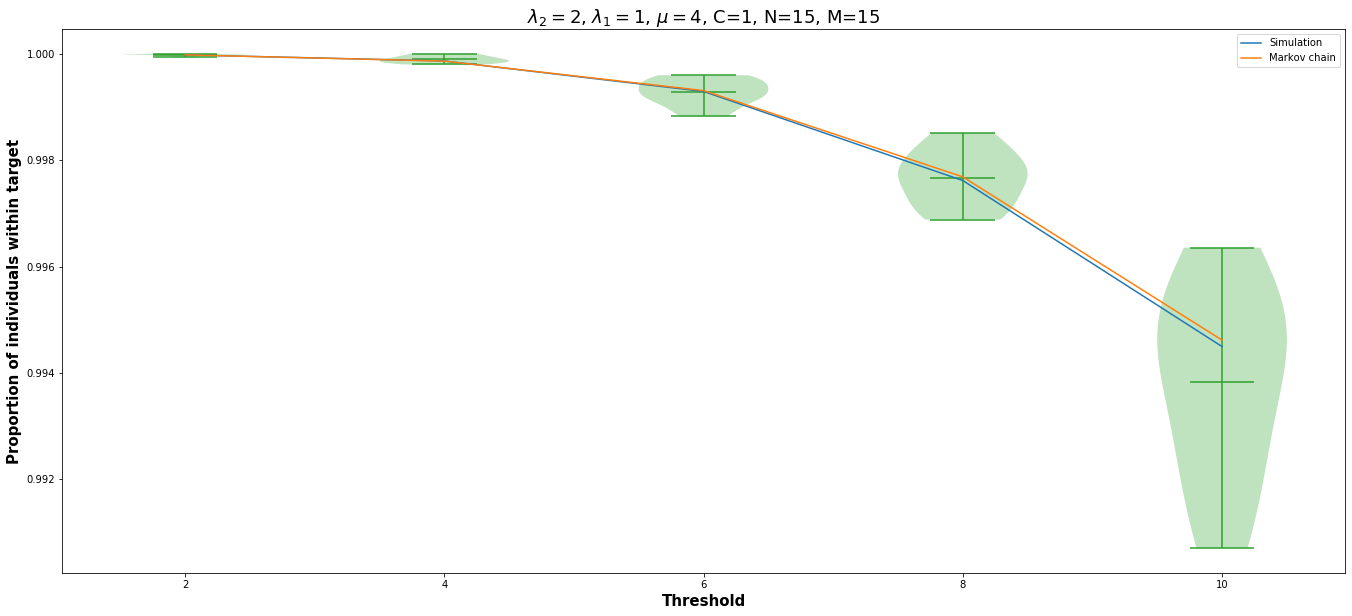

In [70]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    min_threshold=min_threshold,
    max_threshold=max_threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    accuracy=accuracy,
)